# 0.0. Imports

In [1]:
import sys
import os

# create a path that points to the parent directory of the current directory
module_path = os.path.abspath(os.path.join('..'))

# check if the absolute path of the parent directory has been added to the system module search path
if module_path not in sys.path:
    sys.path.append(module_path)

os.chdir(module_path)

In [2]:
import warnings
import pandas          as pd
import numpy           as np
import seaborn         as sns
import sweetviz        as sv
from matplotlib                    import pyplot as plt

from IPython.display               import Image 
from sklearn.cluster               import KMeans
from sklearn.preprocessing         import MinMaxScaler
from yellowbrick.cluster           import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics               import silhouette_score
from scipy.spatial.distance        import pdist, squareform

from __future__                    import print_function
from statsmodels.compat            import lzip
import statsmodels.api             as sm
from statsmodels.formula.api       import ols

/home/mars/.pyenv/versions/3.10.0/envs/ds_prod/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1. Helper functions

### 0.1.1. Settings & data_info

In [3]:
palette = ["#DC143C","#B248BE","#DA1280","#576EE6","#0086ED","#0093D5"]
def jupyter_settings(palette):
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [24, 12]
    plt.rcParams['font.size'] = 24
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set(font_scale=2)
    sns.set_theme(palette=palette)
    warnings.simplefilter("ignore")
    
jupyter_settings(palette)

In [4]:
def num_statistic(data): # para estatisticas descritivas
    #seleção de variáveis numéricas
    num_attributes = data.select_dtypes(include = ('int64', 'float64'))

    #tendencia Central - mean, median ----- dispersão - std, min, max, range, skew, kurtosis
    count_ = pd.DataFrame( num_attributes.count()).T
    range_ = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    min_ = pd.DataFrame( num_attributes.min()).T
    q1 = pd.DataFrame( num_attributes.quantile(0.25)).T
    median_ = pd.DataFrame( num_attributes.apply(np.median)).T
    q3 = pd.DataFrame( num_attributes.quantile(0.75)).T
    max_ = pd.DataFrame( num_attributes.max()).T
    mean_ = pd.DataFrame( num_attributes.apply(np.mean)).T
    std_ = pd.DataFrame( num_attributes.apply(np.std)).T
    skew = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
    kurtosis = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

    #Concatenar
    m = pd.concat( [count_, range_, min_, q1, median_, q3, max_, mean_, std_, skew, kurtosis] ).T.reset_index()
    m.columns = ['attributes', 'count', 'range', 'min', '25%', '50%', '75%', 'max', 'mean', 'std', 'skew', 'kurtosis']
    
    return m

In [5]:
def type_na(data):
    type_ = data.dtypes
    sum_na = data.isna().sum()
    per_na = np.round(data.isna().mean()*100,0).astype(str) + ' %'
    
    metrics = pd.DataFrame({'Type':type_, 'number na': sum_na, 'percent na':per_na})
    
    return metrics

### 0.1.2. Data transformation

In [6]:
def orders_info(orders, order_details):
    # orders merge details
    orders = orders.merge(order_details, on='order_id', how='inner', suffixes=('_orders', '_details'))

    # Transform to datetime format
    orders['order_date'] = pd.to_datetime(orders['order_date'])
    orders['required_date'] = pd.to_datetime(orders['required_date'])
    orders['shipped_date'] = pd.to_datetime(orders['shipped_date'])

    # calculate the final price
    orders['final_price'] = (orders.unit_price * orders.quantity) - orders.discount

    # select cols
    data = orders[['order_id', 'customer_id', 'order_date', 'required_date',
                   'shipped_date', 'ship_via', 'freight', 'product_id', 'unit_price', 
                   'quantity', 'discount', 'final_price']]
    
    # calculate the dalayed days of ship
    data['delayed_days'] = (data.required_date - data.shipped_date).dt.days
    data['delayed_days'] = data['delayed_days'].apply(lambda x: 0 if x > 0 else (x*(-1)))
    
    return data

In [7]:
def order_products( products, data, categories, customer_info):
    # merge products with categories
    products = products.merge(categories, on='category_id',)

    # merge data with products
    orders = data.merge(products, on='product_id')
    
    # merge ordes with customers info
    orders = orders.merge(customer_info, on='customer_id', suffixes=('_orders', '_customerinfo'))

    # select the cols
    df = orders[['order_id', 'customer_id', 'order_date', 'required_date',
                 'shipped_date', 'first_purchase', 'delayed_days', 'avg_delayed_days', 'ship_via', 'freight','product_id', 'unit_price_x', 
                 'quantity', 'discount', 'final_price', 'units_in_stock', 'units_on_order', 'reorder_level',
                 'discontinued', 'category_name', 'churn']]

    # calculate the total purchase per order
    df_aux = (df.groupby('order_id')[['final_price']]
                .sum()
                .reset_index()
                .copy()
                .rename(columns={'final_price':'total_purchase'}))
    
    # merge orders with total purchase series
    df = df.merge(df_aux, on='order_id')
    
    # create cols with time informations
    df['order_year'] = df.order_date.dt.year
    df['order_month'] = df.order_date.dt.month
    df['order_day'] = df.order_date.dt.day
    df['order_day_week'] = df.order_date.dt.dayofweek
    
    

    return df

In [8]:
def customer_information(data):
    # This date is the most recent one, so let's assume this date is today because we need to calculate  the churn 
    today = data.order_date.max()

    # get the last purchase date
    customer_info = data.groupby('customer_id')[['order_date']].max().reset_index()
    customer_info = customer_info.rename(columns = {'order_date': 'last_purchase'})

    # get the first purchase date
    customer_info['first_purchase'] = data.groupby('customer_id')[['order_date']].min().reset_index().order_date.copy()

    # calculate the number of purchases
    customer_info['num_purchases'] = data.groupby('customer_id')[['order_id']].nunique().reset_index().copy().order_id

    # calculate the lifetime of customers
    customer_info['customer_lifetime'] = (customer_info.last_purchase - customer_info.first_purchase).dt.days

    # calculate the average time in days between purchases
    customer_info['avg_time_between_purchase'] = ((customer_info.customer_lifetime) / customer_info.num_purchases).astype(int)

    # calculate the time to the last purchase
    customer_info['time_to_last_purchase'] = (today - customer_info.last_purchase).dt.days

    # calculate the total of payment per customer
    customer_info['total_payment_volume'] = data.groupby('customer_id')[['final_price']].sum().reset_index().copy().final_price

    # calculate the average ticket
    customer_info['average_ticket'] = np.round(customer_info.total_payment_volume / customer_info.num_purchases,2)

    customer_info['nunique_products'] = data.groupby('customer_id')[['product_id']].nunique().reset_index().copy().product_id
    customer_info['nunique_product_rate'] = np.round(customer_info.nunique_products / 77,2)
    customer_info

    # merge customers info with customers
    customer_info = customer_info.merge(customers[['country','customer_id', 'company_name']].copy(), on='customer_id', how='inner')
    
    # calculate the number of purchases
    customer_info['avg_delayed_days'] = data.groupby('customer_id')[['delayed_days']].mean().reset_index().copy().delayed_days

    # select the cols
    customer_info = customer_info[['customer_id', 'company_name', 'country', 'first_purchase', 'last_purchase', 'customer_lifetime', 
                                   'avg_time_between_purchase', 'time_to_last_purchase', 'avg_delayed_days', 'num_purchases','nunique_products','nunique_product_rate', 'total_payment_volume', 'average_ticket']]
    
    return customer_info

### 0.1.3. RFM

In [9]:
def rfm_function(customer_info):

    # select the cols for RFM
    rfm_table = customer_info[['customer_id', 'time_to_last_purchase', 'num_purchases', 'total_payment_volume']].copy()
    rfm_table = rfm_table.rename(columns={'time_to_last_purchase': 'recency', 'num_purchases': 'frequency', 'total_payment_volume':'monetary'})

    # define the intervals
    r_labels = range(5, 0, -1)
    fm_labels = range(1, 6)

    # binning
    rfm_table["R"] = pd.qcut(rfm_table["recency"], 5, labels = r_labels)
    rfm_table["F"] = pd.qcut(rfm_table["frequency"].rank(method = 'first'), 5, labels = fm_labels)
    rfm_table["M"] = pd.qcut(rfm_table["monetary"], 5, labels = fm_labels)

    # make cluster col
    rfm_table["RFM_segment"] = rfm_table["R"].astype(str) + rfm_table["F"].astype(str) + rfm_table["M"].astype(str)

    # make RFM score
    rfm_table["RFM_score"] = rfm_table[["R", "F", "M"]].sum(axis = 1)

    # make a map for name the cluster
    segt_map = {
        r'[1-2][1-2]': 'Hibernating',
        r'[1-2][3-4]': 'At-Risk',
        r'[1-2]5': 'Cannot lose them',
        r'3[1-2]': 'About To Sleep',
        r'33': 'Need Attention',
        r'[3-4][4-5]': 'Loyal Customers',
        r'41': 'Promising',
        r'51': 'New Customers',
        r'[4-5][2-3]': 'Potential Loyalists',
        r'5[4-5]': 'Champions'
    }

    # map cluster
    rfm_table['segment'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str)
    rfm_table['segment'] = rfm_table['segment'].replace(segt_map, regex=True)

    return rfm_table

In [10]:
def plot_rfm(rfm_table):

    ## Visualizing RFM Grid
    rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                       "Loyal Customers": [3, 5, 0.4, 0.8],
                       "Cannot lose them": [4, 5, 0, 0.4],
                       "At-Risk": [2, 4, 0, 0.4],
                       "Hibernating": [0, 2, 0, 0.4],
                       "About To Sleep": [0, 2, 0.4, 0.6],
                       "Promising": [0, 1, 0.6, 0.8],
                       "New Customers": [0, 1, 0.8, 1],
                       "Potential Loyalists": [1, 3, 0.6, 1],
                       "Need Attention": [2, 3, 0.4, 0.6]}

    fig, ax = plt.subplots(figsize = (19, 15))

    ax.set_xlim([0, 5])
    ax.set_ylim([0, 5])

    plt.rcParams["axes.facecolor"] = "white"
    palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
               "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

    for key, color in zip(rfm_coordinates.keys(), palette[:10]):

        coordinates = rfm_coordinates[key]
        ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]

        ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)

        users = rfm_table[rfm_table.segment == key].shape[0]
        users_percentage = (rfm_table[rfm_table.segment == key].shape[0] / rfm_table.shape[0]) * 100
        avg_monetary = rfm_table[rfm_table.segment == key]["monetary"].mean()

        user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
        monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))

        x = 5 * (xmin + xmax) / 2
        y = (ymin + ymax) / 2

        plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
        plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
        plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    

        ax.set_xlabel("Recency Score")
        ax.set_ylabel("Frequency Score")

    sns.despine(left = True, bottom = True)
    plt.show()

    return None

### 0.1.4. Cohort

In [11]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df


def cohort_function(df):
    df_cohort = df.copy()
    df_cohort['mes_ano'] = df_cohort.order_date.apply(lambda x: x.strftime('%Y-%m')).copy()
    df_cohort['cohort'] = df_cohort.first_purchase.apply(lambda x: x.strftime('%Y-%m')).copy()

    cohort = df_cohort.groupby(['cohort', 'mes_ano']).agg({'customer_id': pd.Series.nunique})
    cohort = cohort.rename(columns={'customer_id':'number_customers'})
    cohort = cohort.groupby(level=0).apply(cohort_period)

    cohort = cohort.reset_index()
    cohort = cohort.set_index(['cohort', 'cohort_period'])

    cohort_group_size = cohort['number_customers'].groupby(level=0).first()

    user_retention = cohort['number_customers'].unstack(0).divide(cohort_group_size, axis=1)

    
    plt.rcParams["axes.facecolor"] = "white"

    fig, ax= plt.subplots(figsize=(25, 12))

    plt.title('Porcentagens da taxa de retenção - Monthly Cohorts')
    sns.heatmap(user_retention.T, cmap = "Blues", mask=user_retention.T.isnull(), annot=True, fmt='.2%',  annot_kws = {"fontsize": 12}, cbar = False, ax = ax);
    plt.yticks(rotation=0)
    plt.show() 

### 0.1.5. Cluster and Recommendation Sistem

In [12]:
def heatmap_cluster(data, cluster):
    plt.rcParams["axes.facecolor"] = "white"

    fig, ax= plt.subplots(figsize=(25, 12))
    sns.heatmap( data=(data.query(f'cluster == {cluster}').drop(columns='cluster')), cmap = "Blues", annot=True,  annot_kws = {"fontsize": 12}, cbar = False, ax = ax);
    plt.yticks(rotation=0)
    plt.show() 

In [13]:
def recomendation_system(cluster, customer_id,data,products):
    # make a matrix with the proximity of the points
    sys = pd.DataFrame(1 - squareform(pdist(cluster.set_index('customer_id'), lambda u,v: (u != v).mean())), index=cluster.customer_id.values)
    
    # Rename the columns with customer_id
    sys.columns = cluster.customer_id.values
    
    # get the customer with more similarity
    similar_customer = sys[customer_id].sort_values().index[-2]
    
    # get rate similarity
    similarity = sys[customer_id].sort_values()[-2]
    
    print(f'A customer {customer_id} é similar ao customer {similar_customer} com pontuação de: {similarity}')
    print('\nA lista de produtos recomendados para este customer é:')
    
    # get produt_id
    product_list = (data.query("customer_id == @similar_customer").product_id.unique())
    
    # list of products
    recomended_products = products.loc[products.product_id.isin(product_list)]
    
    return recomended_products

## 0.2. Load Data

|SpreadSheets | Meaning |
| --- | --- |
| orders| A collection of records that represent purchase orders made by customers for specific products. |
| order_details| A collection of records that represent the individual line items in each purchase order, including details such as the product, quantity, and price. |
| products| A collection of records that represent the products available for purchase in the store, including details such as the product name, description, and price. |
| categories| A collection of records that categorize the products, providing an organizational structure for the store's inventory. |
| customer_customer_demo| A table that stores demographic information about the store's customers, such as age, income, and education level. |
| customer_demographics| A collection of records that define various demographic segments for customers, allowing for targeted marketing efforts. |
| customers| A collection of records that represent the store's customers, including details such as their name, address, and contact information. |
| employee_territories| A table that associates employees with specific sales territories, allowing for better management of sales efforts. |
| employees| A collection of records that represent the store's employees, including details such as their name, title, and contact information. |
| region| A collection of records that define various geographic regions, allowing for better management of sales efforts and reporting. |
| shippers| A collection of records that represent the various shipping companies the store uses to fulfill orders, including details such as their name and contact information. |
| suppliers| A collection of records that represent the various suppliers the store uses to purchase products, including details such as their name and contact information. |
| territories| A collection of records that define various sales territories, allowing for better management of sales efforts and reporting. |
| us_states| A collection of records that represent the various states in the US, allowing for better management of sales efforts and reporting based on location. |




In [14]:
orders = pd.read_csv('data/orders.csv', sep=';')
order_details = pd.read_csv('data/order_details.csv', sep=';')
products = pd.read_csv('data/products.csv', sep=';')
categories = pd.read_csv('data/categories.csv', sep=';')
customer_customer_demo = pd.read_csv('data/customer_customer_demo.csv', sep=';')
customer_demographics = pd.read_csv('data/customer_demographics.csv', sep=';')
customers = pd.read_csv('data/customers.csv', sep=';')
employee_territories = pd.read_csv('data/employee_territories.csv', sep=';')
employees = pd.read_csv('data/employees.csv', sep=';')
region = pd.read_csv('data/region.csv', sep=';')
shippers = pd.read_csv('data/shippers.csv', sep=';')
suppliers = pd.read_csv('data/suppliers.csv', sep=';')
territories = pd.read_csv('data/territories.csv', sep=';')
us_states = pd.read_csv('data/us_states.csv', sep=';')

# 1.0. Data Describe

## 1.1. Data Dimensions

In [15]:
print(f'{orders.shape} = orders')
print(f'{order_details.shape} = order_details')
print(f'{products.shape}  = products')
print(f'{categories.shape}    = categories')
print(f'{customer_customer_demo.shape}    = customer_customer_demo')
print(f'{customer_demographics.shape}    = customer_demographics')
print(f'{customers.shape}  = customers')
print(f'{employee_territories.shape}   = employee_territories')
print(f'{employees.shape}   = employees')
print(f'{region.shape}    = region')
print(f'{shippers.shape}    = shippers')
print(f'{suppliers.shape}  = suppliers')
print(f'{territories.shape}   = territories')
print(f'{us_states.shape}   = us_states')

(830, 14) = orders
(2155, 5) = order_details
(77, 10)  = products
(8, 4)    = categories
(0, 2)    = customer_customer_demo
(0, 2)    = customer_demographics
(91, 11)  = customers
(49, 2)   = employee_territories
(9, 18)   = employees
(4, 2)    = region
(6, 3)    = shippers
(29, 12)  = suppliers
(53, 3)   = territories
(51, 4)   = us_states


## 1.2. Data info()

In [16]:
print('\n---- orders ----')
print(type_na(orders))
print('\n---- order_details ----')
print(type_na(order_details))
print('\n---- products ----')
print(type_na(products))
print('\n---- categories ----')
print(type_na(categories))
print('\n---- customer_customer_demo ----')
print(type_na(customer_customer_demo))
print('\n---- customer_demographics ----')
print(type_na(customer_demographics))
print('\n---- customers ----')
print(type_na(customers))
print('\n---- employee_territories ----')
print(type_na(employee_territories))
print('\n---- employees ----')
print(type_na(employees))
print('\n---- region ----')
print(type_na(region))
print('\n---- shippers ----')
print(type_na(shippers))
print('\n---- suppliers ----')
print(type_na(suppliers))
print('\n---- territories ----')
print(type_na(territories))
print('\n---- us_states ----')
print(type_na(us_states))


---- orders ----
                     Type  number na percent na
order_id            int64          0      0.0 %
customer_id        object          0      0.0 %
employee_id         int64          0      0.0 %
order_date         object          0      0.0 %
required_date      object          0      0.0 %
shipped_date       object         21      3.0 %
ship_via            int64          0      0.0 %
freight           float64          0      0.0 %
ship_name          object          0      0.0 %
ship_address       object          0      0.0 %
ship_city          object          0      0.0 %
ship_region        object        507     61.0 %
ship_postal_code   object         19      2.0 %
ship_country       object          0      0.0 %

---- order_details ----
               Type  number na percent na
order_id      int64          0      0.0 %
product_id    int64          0      0.0 %
unit_price  float64          0      0.0 %
quantity      int64          0      0.0 %
discount    float64        

# 2.0. Feature Engineering and EDA

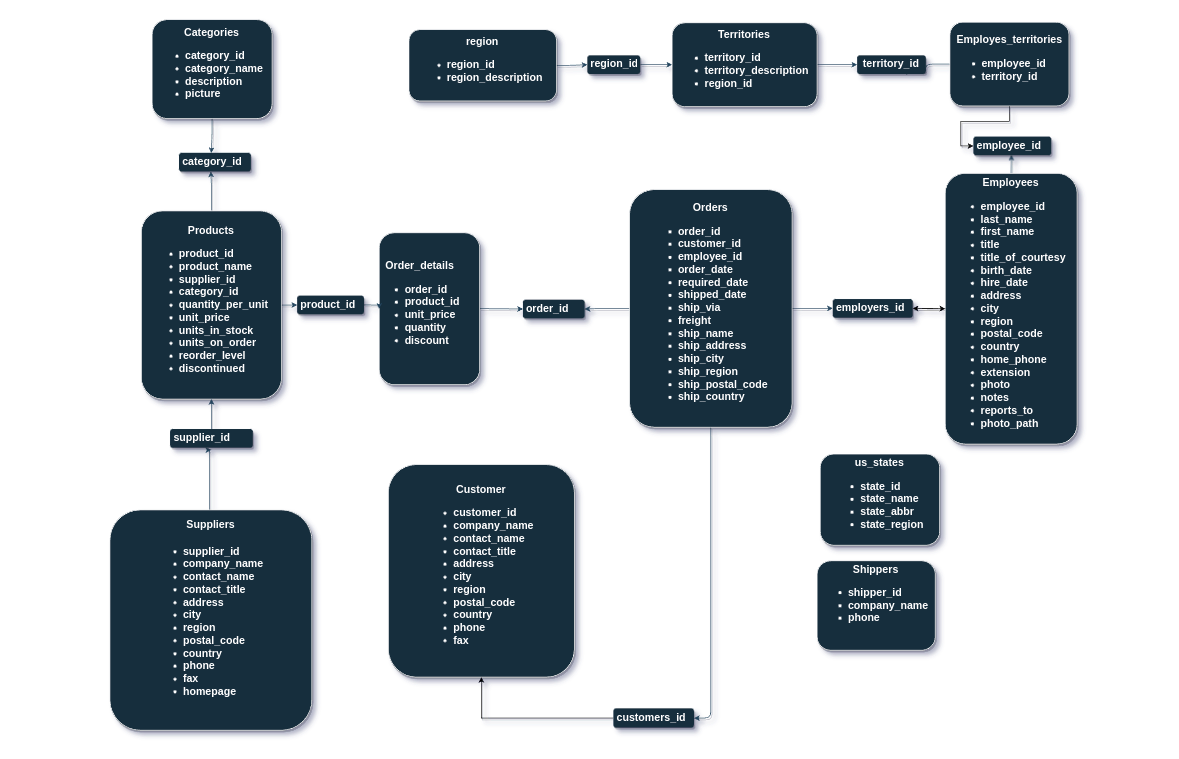

In [17]:
mer = Image(filename='img/mer.png')
display(mer)

### 2.1. Data Transformation

In [18]:
# applying data function in orders dataframes
data = orders_info(orders, order_details)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2154
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       2155 non-null   int64         
 1   customer_id    2155 non-null   object        
 2   order_date     2155 non-null   datetime64[ns]
 3   required_date  2155 non-null   datetime64[ns]
 4   shipped_date   2082 non-null   datetime64[ns]
 5   ship_via       2155 non-null   int64         
 6   freight        2155 non-null   float64       
 7   product_id     2155 non-null   int64         
 8   unit_price     2155 non-null   float64       
 9   quantity       2155 non-null   int64         
 10  discount       2155 non-null   float64       
 11  final_price    2155 non-null   float64       
 12  delayed_days   2082 non-null   float64       
dtypes: datetime64[ns](3), float64(5), int64(4), object(1)
memory usage: 235.7+ KB


In [19]:
# applying customer function
customer_info = customer_information(data)
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 0 to 88
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   customer_id                89 non-null     object        
 1   company_name               89 non-null     object        
 2   country                    89 non-null     object        
 3   first_purchase             89 non-null     datetime64[ns]
 4   last_purchase              89 non-null     datetime64[ns]
 5   customer_lifetime          89 non-null     int64         
 6   avg_time_between_purchase  89 non-null     int64         
 7   time_to_last_purchase      89 non-null     int64         
 8   avg_delayed_days           89 non-null     float64       
 9   num_purchases              89 non-null     int64         
 10  nunique_products           89 non-null     int64         
 11  nunique_product_rate       89 non-null     float64       
 12  total_paym

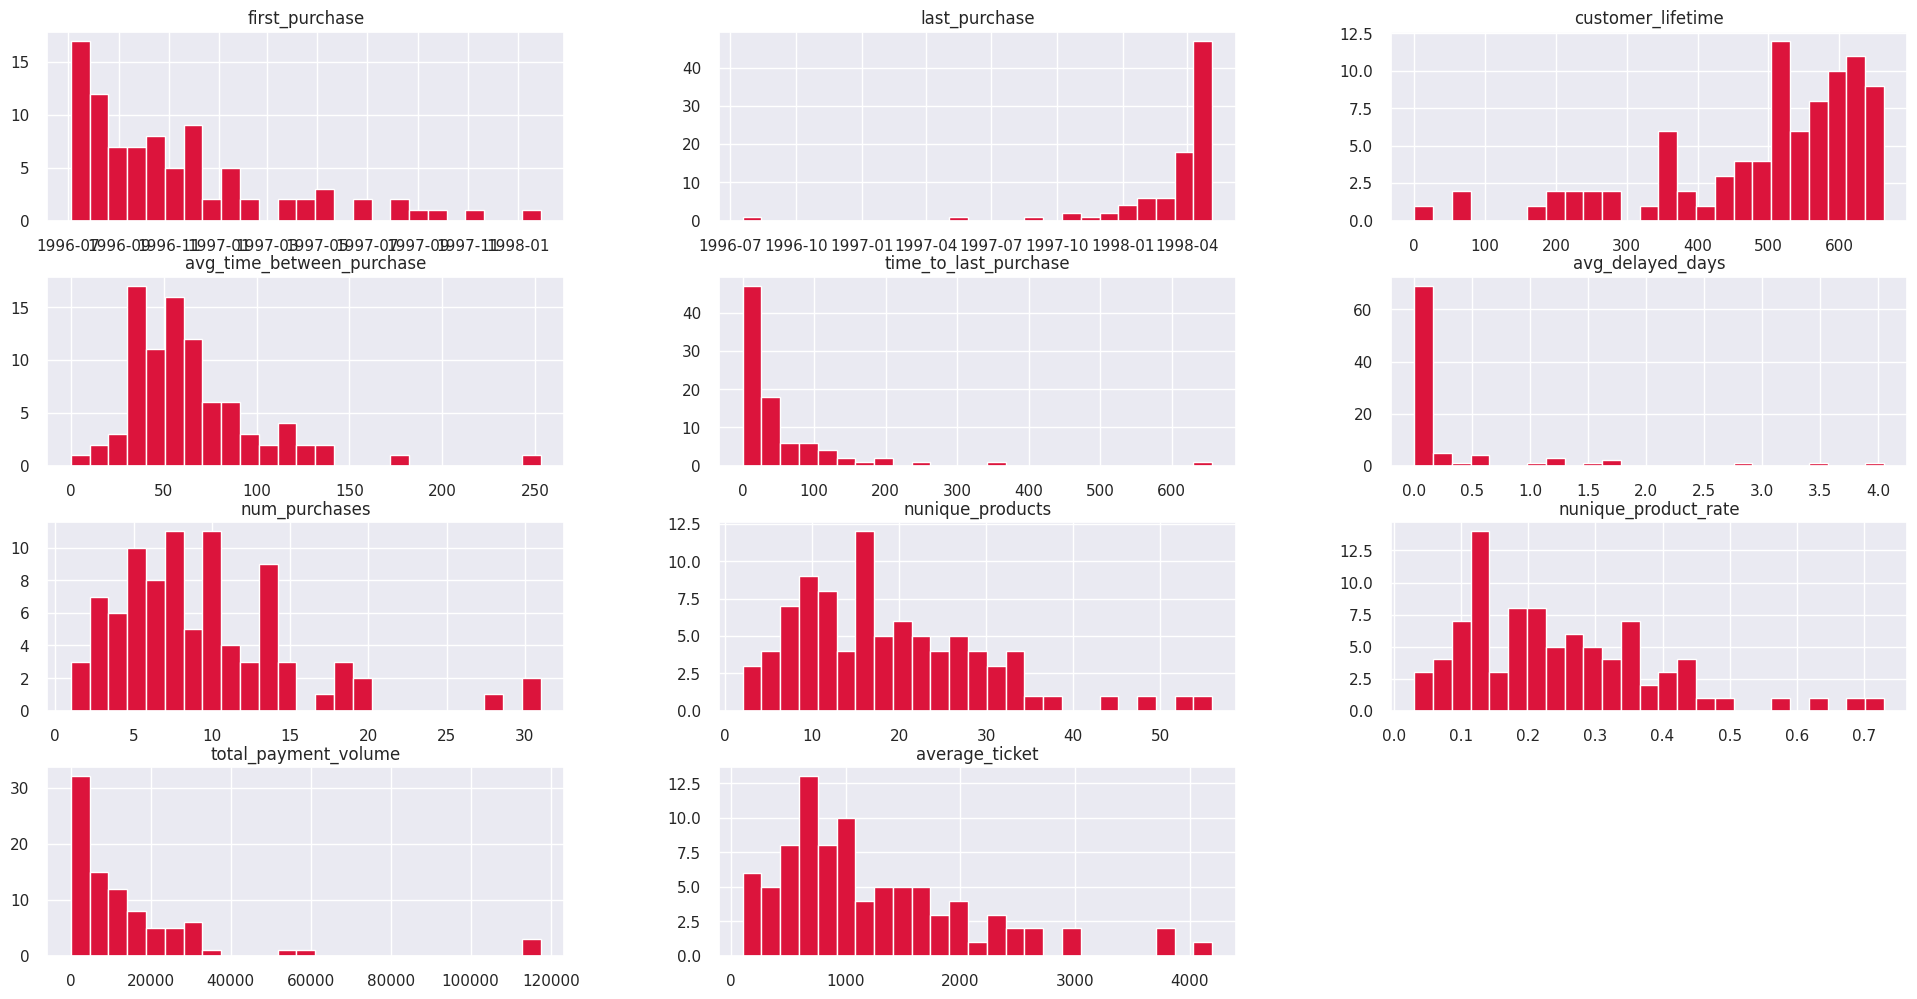

In [20]:
customer_info.hist(bins=25);

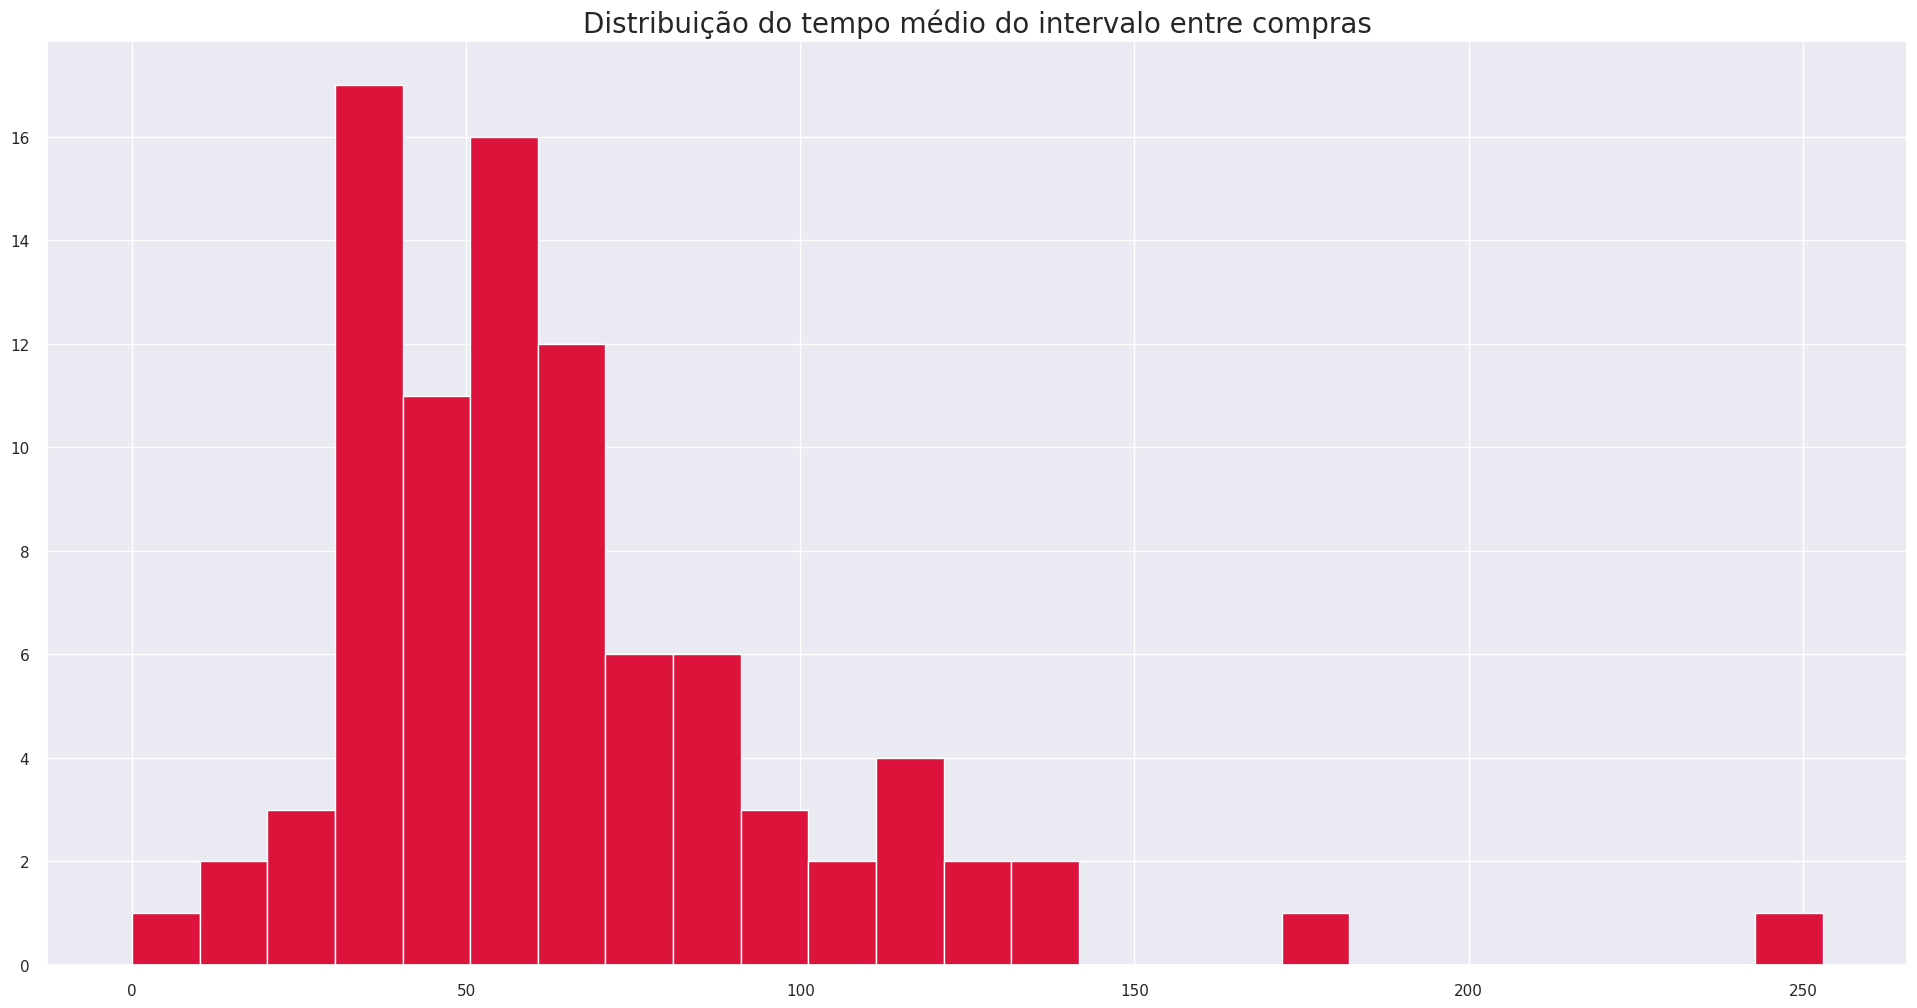

In [21]:
customer_info.avg_time_between_purchase.hist(bins=25);
plt.title('Distribuição do tempo médio do intervalo entre compras', fontsize=20);

#### <span style="color: #FF6565;"> Based on the analysis above, the churn period is set to 70 days, as after 70 days the average time between purchases drop </span>

In [22]:
customer_info['churn'] = customer_info.time_to_last_purchase > 70

Orders info + Customer Churn

In [23]:
orders_info = order_products( products, data, categories, customer_info)
orders_info

,order_id,customer_id,order_date,required_date,shipped_date,first_purchase,delayed_days,avg_delayed_days,ship_via,freight,product_id,unit_price_x,quantity,discount,final_price,units_in_stock,units_on_order,reorder_level,discontinued,category_name,churn,total_purchase,order_year,order_month,order_day,order_day_week
0,10248,VINET,1996-07-04,1996-08-01,1996-07-16,1996-07-04,0.0,0.0,3,32.38,11,14.00,12,0.0,168.00,22,30,30,0,Dairy Products,True,440.00,1996,7,4,3
1,10248,VINET,1996-07-04,1996-08-01,1996-07-16,1996-07-04,0.0,0.0,3,32.38,42,9.80,10,0.0,98.00,26,0,0,1,Grains/Cereals,True,440.00,1996,7,4,3
2,10248,VINET,1996-07-04,1996-08-01,1996-07-16,1996-07-04,0.0,0.0,3,32.38,72,34.80,5,0.0,174.00,14,0,0,0,Dairy Products,True,440.00,1996,7,4,3
3,10274,VINET,1996-08-06,1996-09-03,1996-08-16,1996-07-04,0.0,0.0,1,6.01,72,27.80,7,0.0,194.60,14,0,0,0,Dairy Products,True,538.60,1996,8,6,1
4,10274,VINET,1996-08-06,1996-09-03,1996-08-16,1996-07-04,0.0,0.0,1,6.01,71,17.20,20,0.0,344.00,26,0,0,0,Dairy Products,True,538.60,1996,8,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,10624,THECR,1997-08-07,1997-09-04,1997-08-19,1997-08-07,0.0,0.0,2,94.80,29,123.79,6,0.0,742.74,0,0,0,1,Meat/Poultry,False,1393.24,1997,8,7,3
2151,10624,THECR,1997-08-07,1997-09-04,1997-08-19,1997-08-07,0.0,0.0,2,94.80,28,45.60,10,0.0,456.00,26,0,0,1,Produce,False,1393.24,1997,8,7,3
2152,10624,THECR,1997-08-07,1997-09-04,1997-08-19,1997-08-07,0.0,0.0,2,94.80,44,19.45,10,0.0,194.50,27,0,15,0,Condiments,False,1393.24,1997,8,7,3
2153,10775,THECR,1997-12-12,1998-01-09,1997-12-26,1997-08-07,0.0,0.0,1,20.25,10,31.00,6,0.0,186.00,31,0,0,0,Seafood,False,228.00,1997,12,12,4


### 2.2. EDA

### 2.1. Descriptive Statistics

In [24]:
num_statistic(customer_info)

,attributes,count,range,min,25%,50%,75%,max,mean,std,skew,kurtosis
0,customer_lifetime,89.0,663.000000,0.00,427.00,530.00,602.00,663.000000,490.460674,151.132657,-1.296259,1.218658
1,avg_time_between_purchase,89.0,253.000000,0.00,40.00,58.00,79.00,253.000000,64.853933,36.900580,2.010059,7.037363
2,time_to_last_purchase,89.0,657.000000,0.00,8.00,23.00,58.00,657.000000,51.561798,86.991405,4.530258,26.954622
3,avg_delayed_days,89.0,4.052632,0.00,0.00,0.00,0.10,4.052632,0.276300,0.713397,3.570836,13.784386
4,num_purchases,89.0,30.000000,1.00,5.00,8.00,12.00,31.000000,9.325843,5.778253,1.534226,3.306674
5,nunique_products,89.0,54.000000,2.00,10.00,17.00,25.00,56.000000,18.932584,10.990085,1.086790,1.426675
6,nunique_product_rate,89.0,0.700000,0.03,0.13,0.22,0.32,0.730000,0.245843,0.143031,1.094898,1.448431
7,total_payment_volume,89.0,117376.640000,100.80,3361.00,7553.80,18136.35,117477.440000,15217.275843,21826.626002,3.413447,13.141157
8,average_ticket,89.0,4094.820000,100.80,614.63,1057.39,1632.36,4195.620000,1229.429213,847.885362,1.275700,1.710127


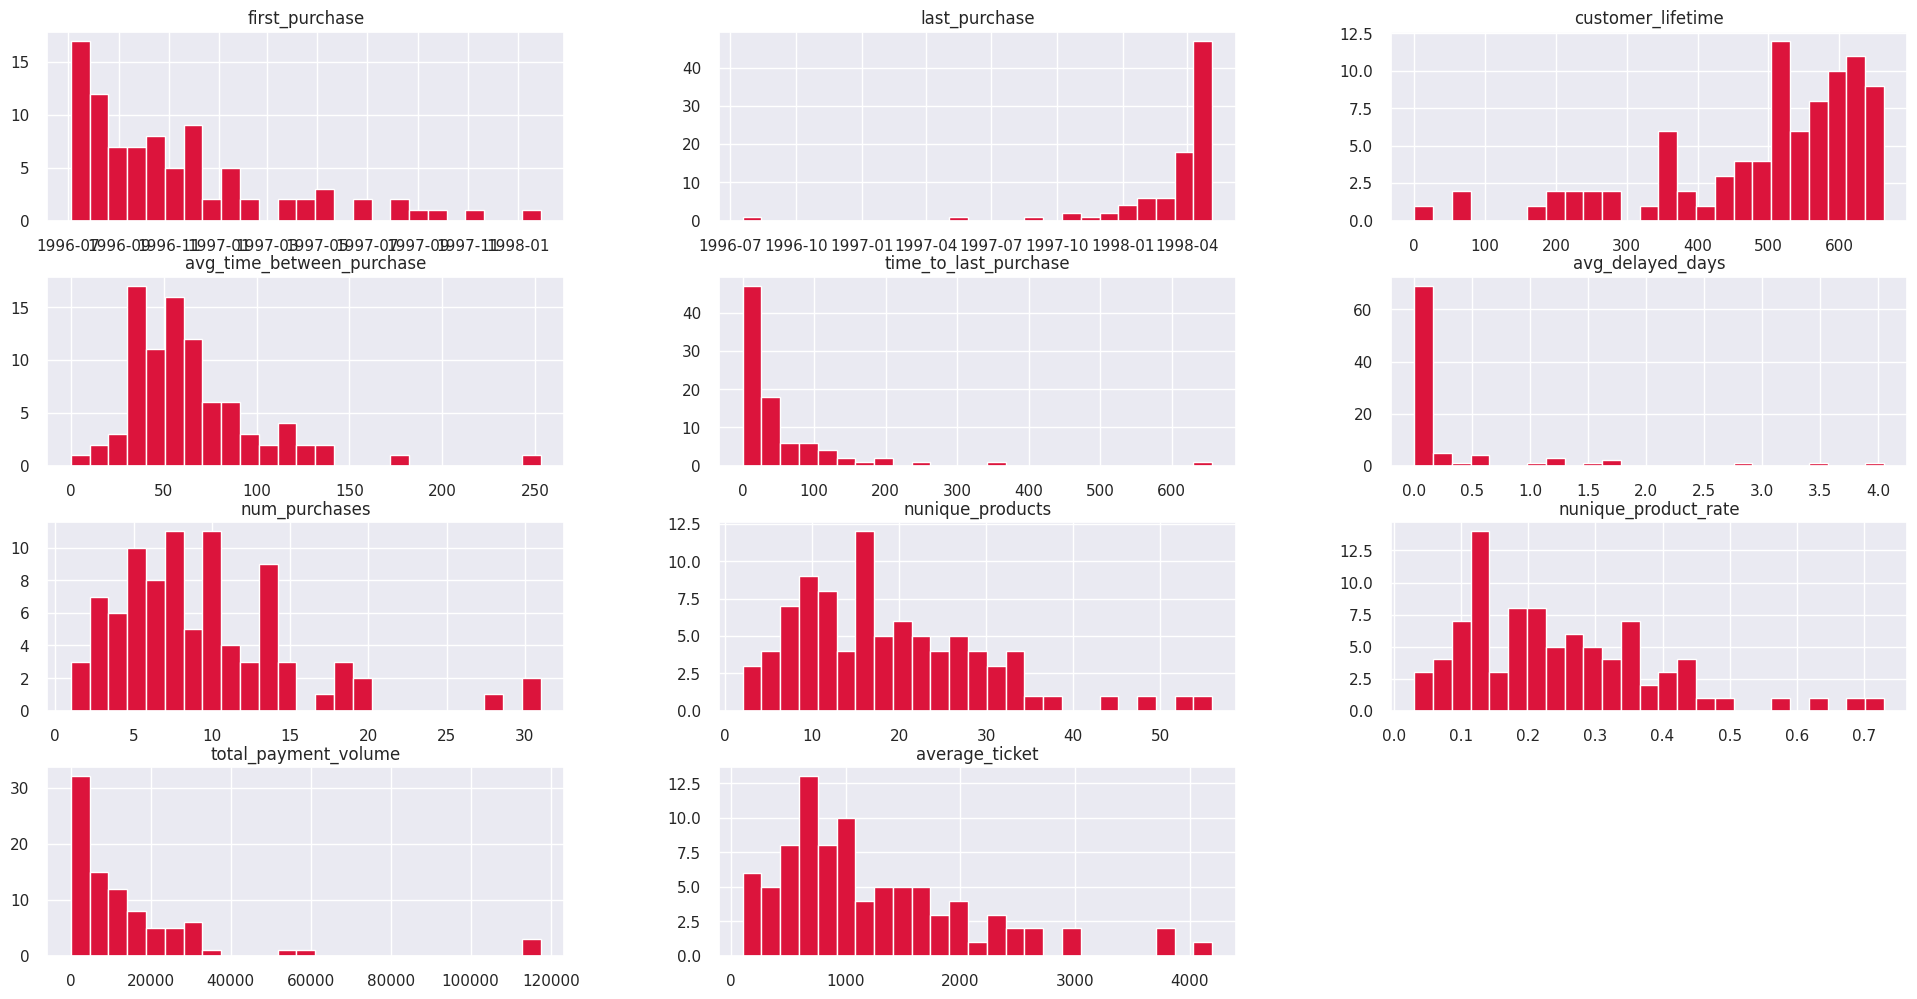

In [25]:
customer_info.hist(bins=25);

In [26]:
# Most NorthWind customers have a high lifetime
# Most NorthWind customers have a low avg_time_between_purchase
# Most NorthWind customers have a low num_purchases
# Most NorthWind customers have a low total_payment_volume

In [27]:
num_statistic(orders_info)

,attributes,count,range,min,25%,50%,75%,max,mean,std,skew,kurtosis
0,order_id,2155.0,829.000000,10248.00,10451.00,10657.0,10862.500000,11077.000000,10659.375870,241.322022,0.038054,-1.190324
1,delayed_days,2082.0,23.000000,0.00,0.00,NaN,0.000000,23.000000,0.272815,1.639604,7.958161,74.038578
2,avg_delayed_days,2155.0,4.052632,0.00,0.00,0.0,0.258621,4.052632,0.268485,0.571289,3.627376,17.527351
3,ship_via,2155.0,2.000000,1.00,1.00,2.0,3.000000,3.000000,1.999536,0.773997,0.000798,-1.331054
4,freight,2155.0,1007.620000,0.02,19.61,53.8,120.920000,1007.640000,96.197726,132.980407,3.251078,13.580398
5,product_id,2155.0,76.000000,1.00,22.00,41.0,60.000000,77.000000,40.793039,22.153878,-0.079569,-1.176630
6,unit_price_x,2155.0,261.500000,2.00,12.00,18.4,32.000000,263.500000,26.218520,29.820497,5.102435,33.860159
7,quantity,2155.0,129.000000,1.00,10.00,20.0,30.000000,130.000000,23.812993,19.017633,1.782479,4.602500
8,discount,2155.0,0.250000,0.00,0.00,0.0,0.100000,0.250000,0.056167,0.083431,1.208363,-0.007008
9,final_price,2155.0,15805.200000,4.80,154.00,360.0,722.150000,15810.000000,628.462900,1036.220838,6.782272,68.777062


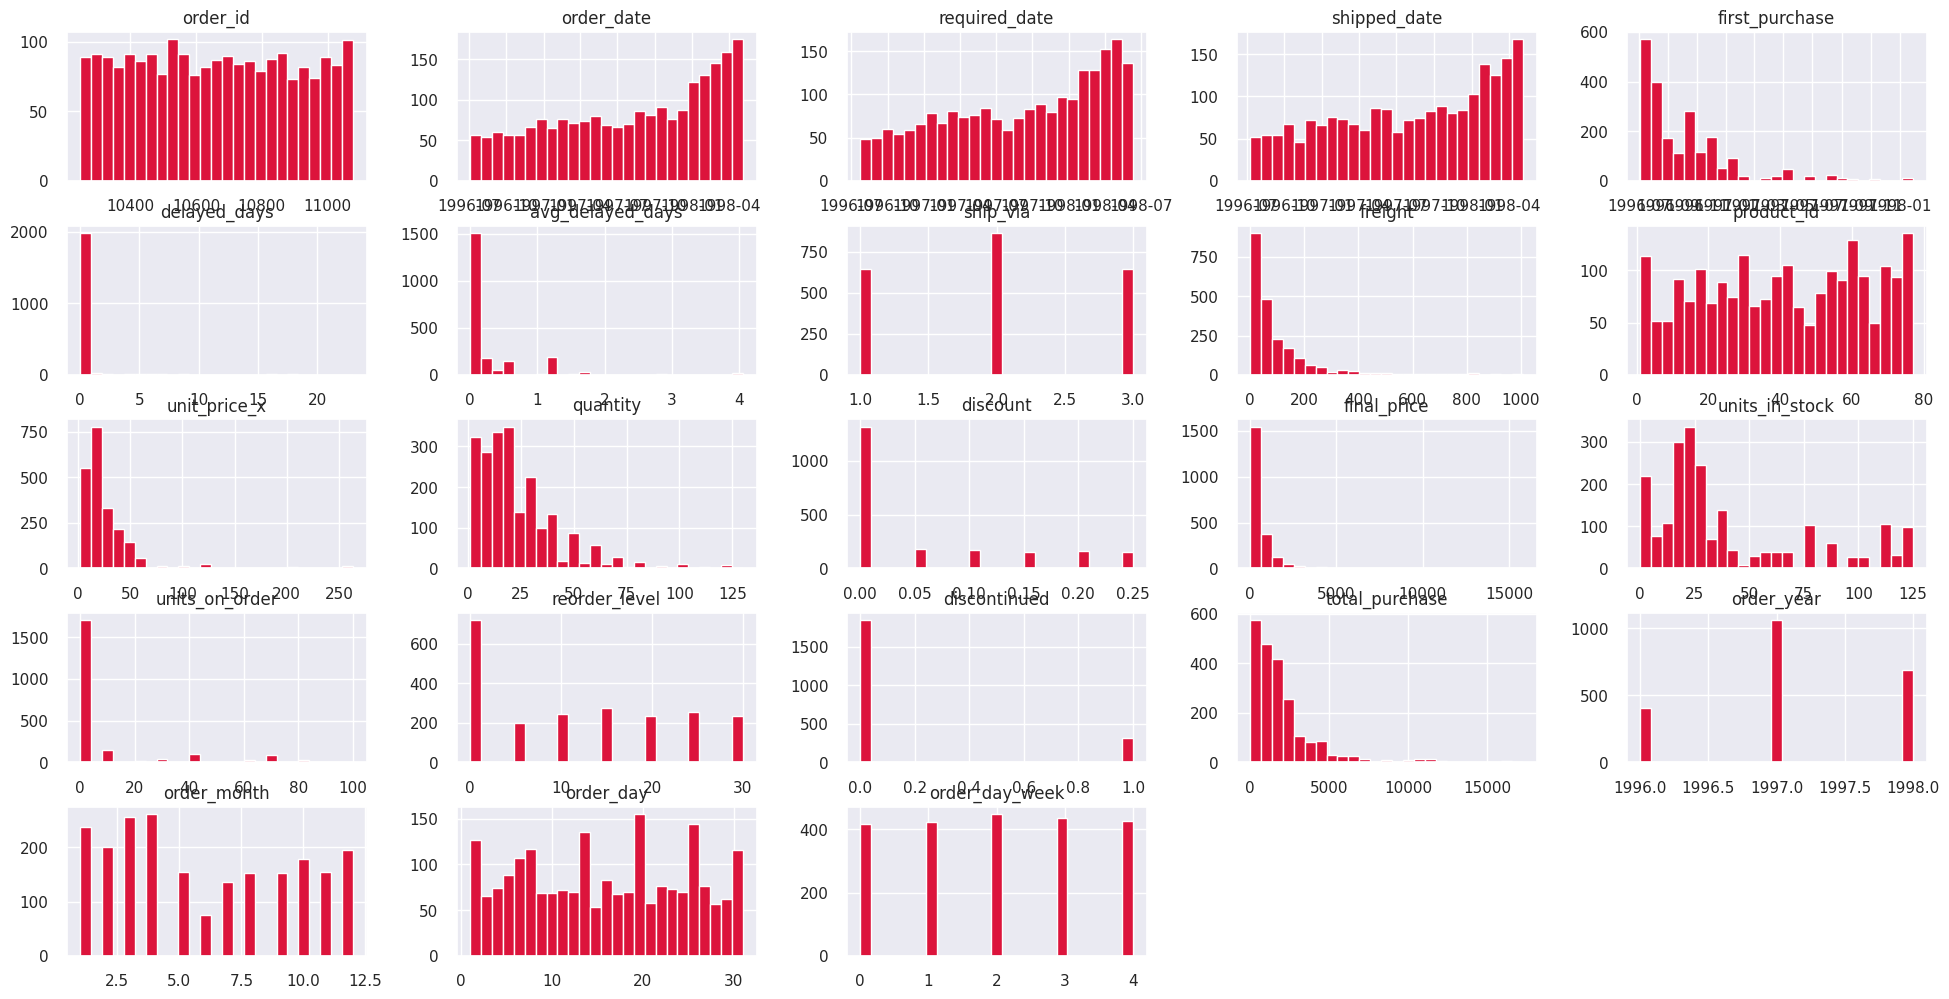

In [28]:
orders_info.hist(bins=25);

In [29]:
# Most NorthWind orders have a low freight
# Most NorthWind orders have a low quantity
# Most NorthWind orders have a low unit_price

### 2.2. Sweetviz

In exploratory data analysis, I will use Sweetviz, for time saving reasons

In [30]:
sv_report_an1 = sv.analyze(customer_info, target_feat="churn")
sv_report_an1.show_html(filepath='reports/sweetviz_customer_info.html',open_browser=False)

sv_report_an2 = sv.analyze(source=orders_info, target_feat="churn")
sv_report_an2.show_html(filepath='reports/sweetviz_orders_info.html',open_browser=False)

Done! Use 'show' commands to display/save.   |██| [100%]   00:00 -> (00:00 left)


Report reports/sweetviz_customer_info.html was generated.


Done! Use 'show' commands to display/save.   |██| [100%]   00:01 -> (00:00 left)

Report reports/sweetviz_orders_info.html was generated.


# 3.0. Cohort Analysis

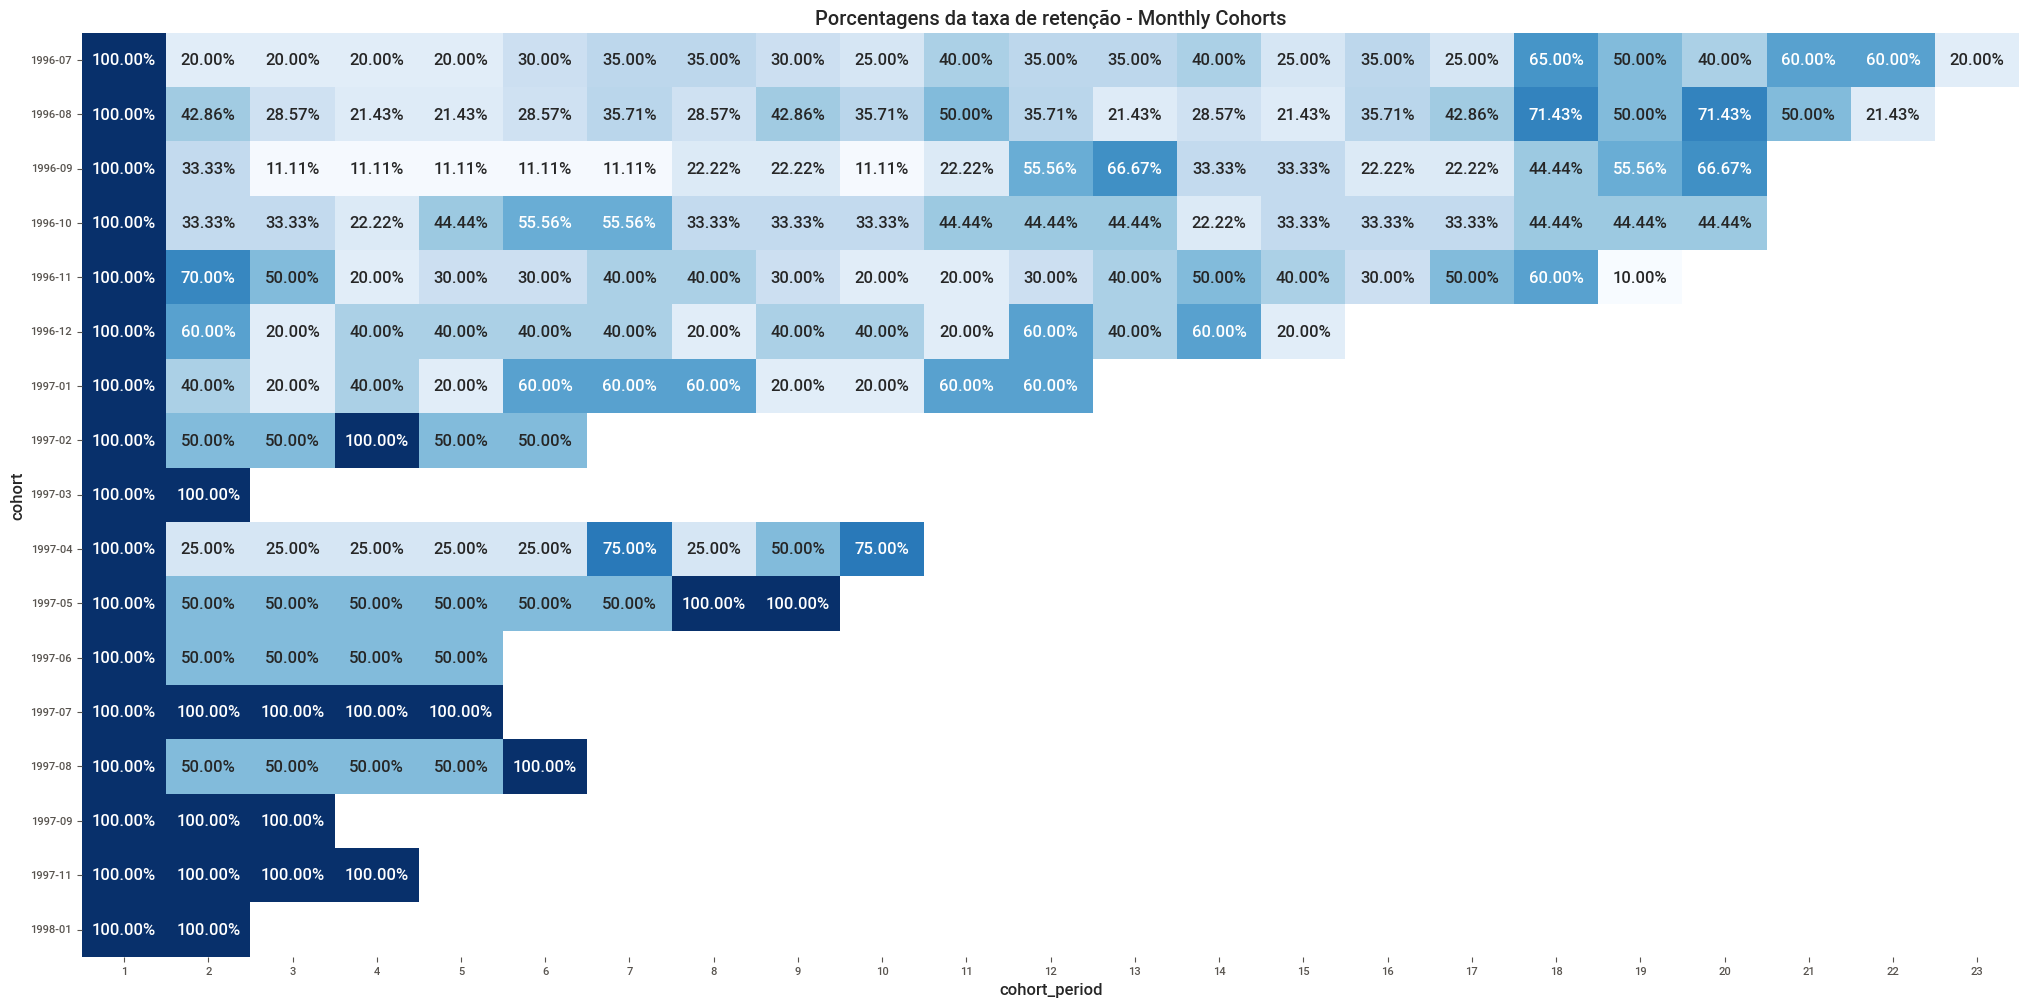

In [31]:
cohort_function(orders_info)

In [32]:
cohort_orders = orders_info.copy()
cohort_orders.first_purchase = cohort_orders.first_purchase.apply(lambda x: x.strftime('%Y-%m'))
cohort_orders.query('first_purchase == "1997-03"')

,order_id,customer_id,order_date,required_date,shipped_date,first_purchase,delayed_days,avg_delayed_days,ship_via,freight,product_id,unit_price_x,quantity,discount,final_price,units_in_stock,units_on_order,reorder_level,discontinued,category_name,churn,total_purchase,order_year,order_month,order_day,order_day_week
398,10545,LAZYK,1997-05-22,1997-06-19,1997-06-26,1997-03,7.0,3.5,2,11.92,11,21.0,10,0.0,210.0,22,30,30,0,Dairy Products,True,210.0,1997,5,22,3
399,10482,LAZYK,1997-03-21,1997-04-18,1997-04-10,1997-03,0.0,3.5,3,7.48,40,14.7,10,0.0,147.0,123,0,30,0,Seafood,True,147.0,1997,3,21,4


In [33]:
# the gap in 1997-03 is because the customer on that line only made 2 purchases

In [34]:
cohort_orders.query('first_purchase == "1997-02"').sort_values('order_date')

,order_id,customer_id,order_date,required_date,shipped_date,first_purchase,delayed_days,avg_delayed_days,ship_via,freight,product_id,unit_price_x,quantity,discount,final_price,units_in_stock,units_on_order,reorder_level,discontinued,category_name,churn,total_purchase,order_year,order_month,order_day,order_day_week
1476,10435,CONSH,1997-02-04,1997-03-18,1997-02-07,1997-02,0.0,0.0,2,9.21,72,27.80,10,0.0,278.0,14,0,0,0,Dairy Products,True,631.6,1997,2,4,1
1477,10435,CONSH,1997-02-04,1997-03-18,1997-02-07,1997-02,0.0,0.0,2,9.21,22,16.80,12,0.0,201.6,104,0,25,0,Grains/Cereals,True,631.6,1997,2,4,1
1478,10435,CONSH,1997-02-04,1997-03-18,1997-02-07,1997-02,0.0,0.0,2,9.21,2,15.20,10,0.0,152.0,17,40,25,1,Beverages,True,631.6,1997,2,4,1
1826,10448,RANCH,1997-02-17,1997-03-17,1997-02-24,1997-02,0.0,1.6,2,38.82,40,14.70,20,0.0,294.0,123,0,30,0,Seafood,False,443.4,1997,2,17,0
1827,10448,RANCH,1997-02-17,1997-03-17,1997-02-24,1997-02,0.0,1.6,2,38.82,26,24.90,6,0.0,149.4,15,0,0,0,Confections,False,443.4,1997,2,17,0
1481,10462,CONSH,1997-03-03,1997-03-31,1997-03-18,1997-02,0.0,0.0,1,6.17,13,4.80,1,0.0,4.8,24,0,5,0,Seafood,True,156.0,1997,3,3,0
1482,10462,CONSH,1997-03-03,1997-03-31,1997-03-18,1997-02,0.0,0.0,1,6.17,23,7.20,21,0.0,151.2,61,0,25,0,Grains/Cereals,True,156.0,1997,3,3,0
1816,10716,RANCH,1997-10-24,1997-11-21,1997-10-27,1997-02,0.0,1.6,2,22.57,51,53.00,7,0.0,371.0,20,0,10,0,Produce,False,706.0,1997,10,24,4
1817,10716,RANCH,1997-10-24,1997-11-21,1997-10-27,1997-02,0.0,1.6,2,22.57,21,10.00,5,0.0,50.0,3,40,5,0,Confections,False,706.0,1997,10,24,4
1818,10716,RANCH,1997-10-24,1997-11-21,1997-10-27,1997-02,0.0,1.6,2,22.57,61,28.50,10,0.0,285.0,113,0,25,0,Condiments,False,706.0,1997,10,24,4


In [35]:
# something similar happened in the 1997 queue, the 2 customers responsible for that group stop to buy

# 4.0. Churn Analysis

In [36]:
jupyter_settings(palette)

### <span style="color: red;"> H1 - The churn rate over the customer's lifetime is increasing
#### <span style="color: red;"> False </span> - Customer lifetime churn rate is not increasing. 

#### That's a good sign because if a customer's lifetime churn rate is increasing, it could mean the products aren't good.

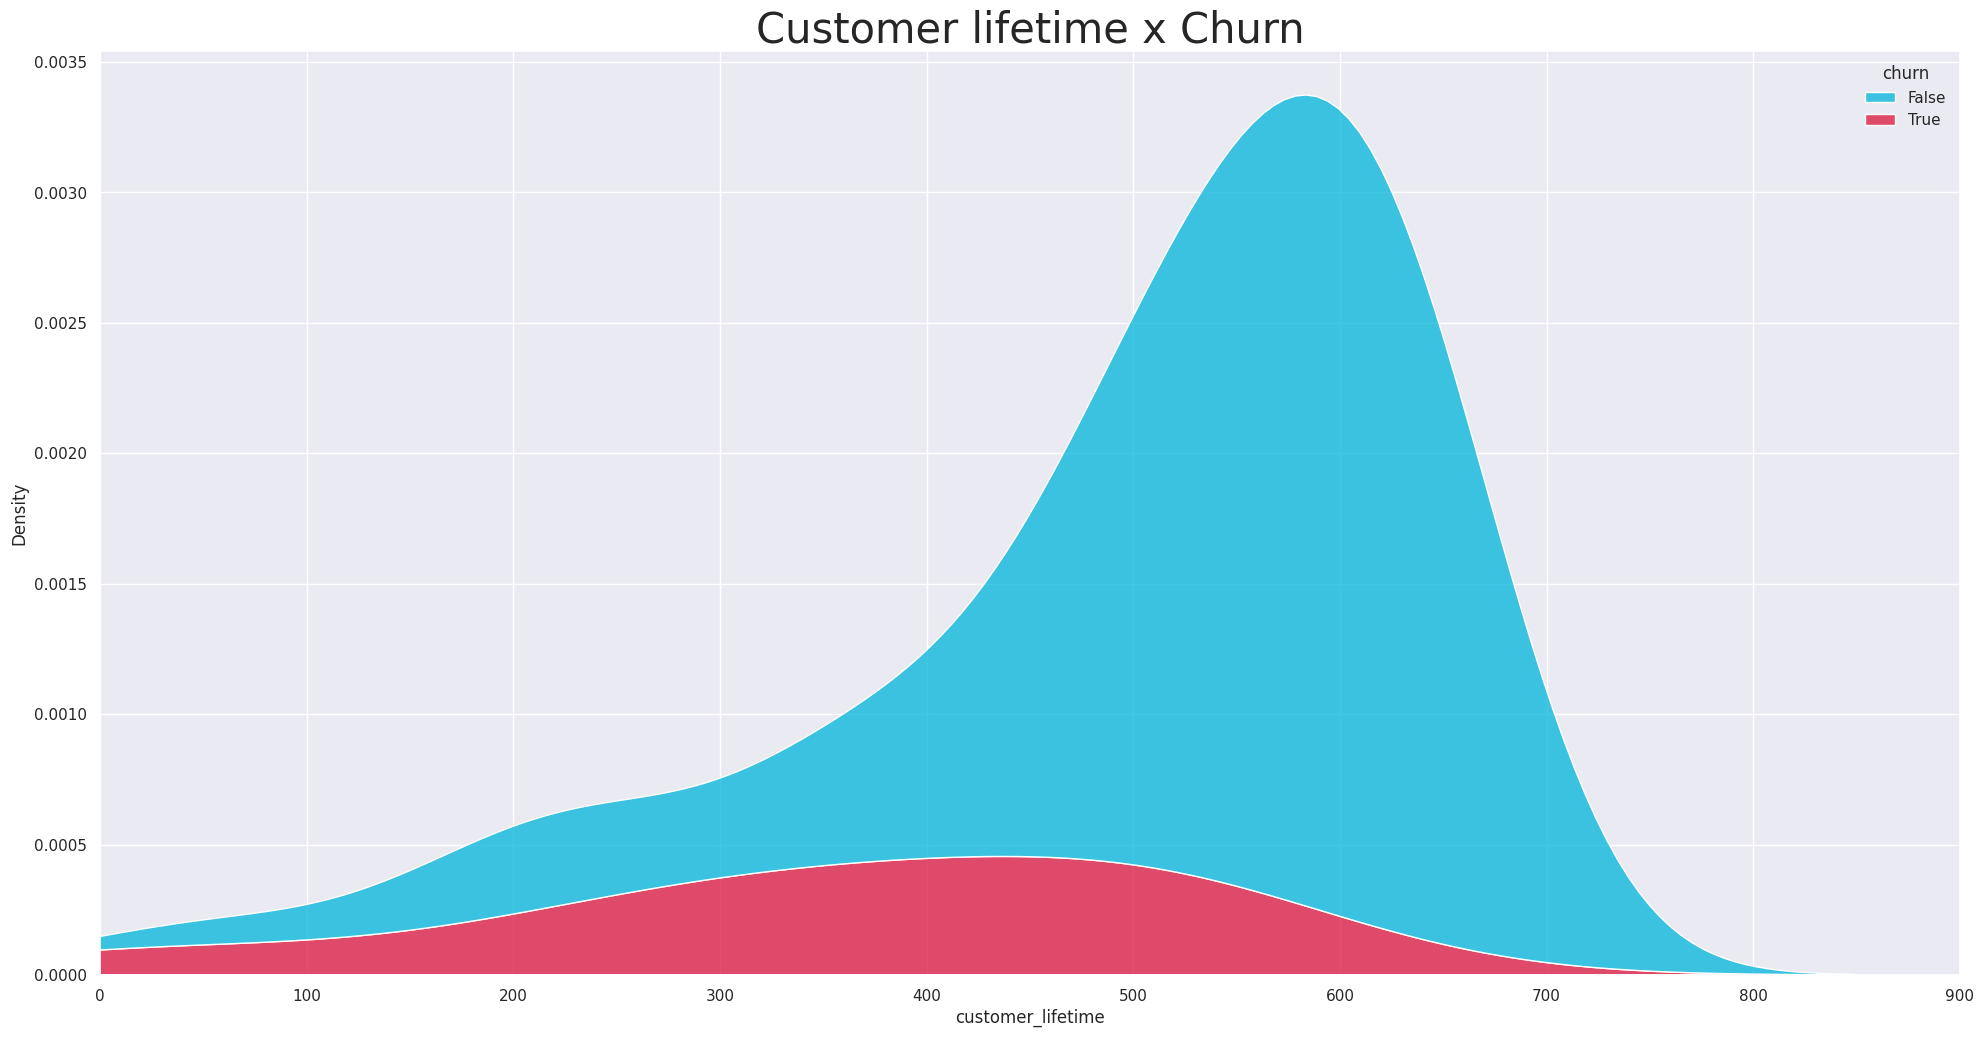

In [37]:
aux = customer_info.copy()
aux = aux.sort_values('customer_lifetime')

sns.kdeplot(data=aux, x='customer_lifetime', hue='churn',multiple="stack", palette=['#00B5DB', '#DC143C'])
plt.xlim(0,900)
plt.title('Customer lifetime x Churn', fontsize=30);

### <span style="color: red;">H2 - The churn rate is 30%
#### <span style="color: red;">False </span> - The churn rate is 20.22%

In [38]:
churn_rate = (f'The churn rate is {np.round(aux.churn.mean()*100,2)}%')
print(churn_rate)

The churn rate is 20.22%


### <span style="color: red;">H3 - USA is the country with the most churn
#### <span style="color: red;"> False </span> - France is the country with the most churn, with 5 customers in churn ( 50% churn rate )

In [39]:
aux = (customer_info.groupby('country')[['churn']]
                    .sum()
                    .reset_index()
                    .copy())

aux['customers_per_country'] = ( customer_info.groupby('country')[['churn']]
                                              .count()
                                              .reset_index()
                                              .copy()
                                              .churn )

aux['churnrate'] = np.round( aux.churn / aux.customers_per_country * 100)

aux = aux.sort_values('churn',ascending=False)

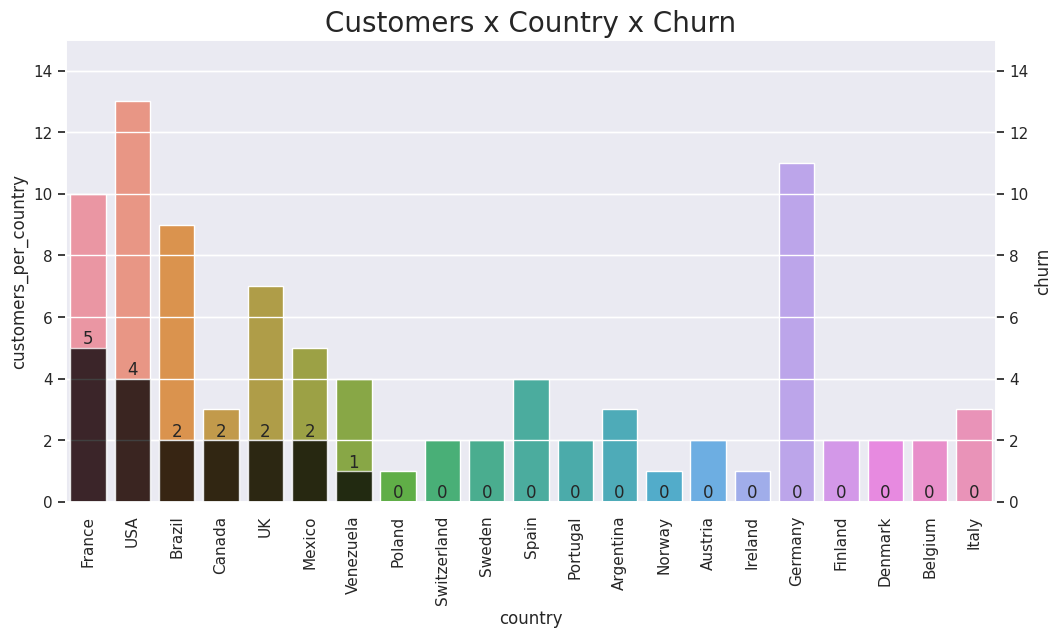

In [40]:
fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(data = aux, x='country', y='customers_per_country', alpha=1, ax=ax1)
plt.ylim(0, 15)
plt.xticks(rotation=90);
plt.title('Customers x Country x Churn',fontsize=20)

ax2 = ax1.twinx()

ax=sns.barplot(data = aux, x='country', y='churn', ax=ax2, alpha=0.75, palette=['black'])
plt.ylim(0, 15)
plt.xticks(rotation=90);
for i in ax.containers:
    ax.bar_label(i,)

### <span style="color: lightgreen;"> H4 - Orders with ship_via = 3 have more churn in mean
#### <span style="color: lightgreen;">True</span> - Orders with ship_via 3 have more churn, **is necessary to identify with deliveries what is happening**

Text(0.5, 1.0, 'Ship x delayed_days x churn')

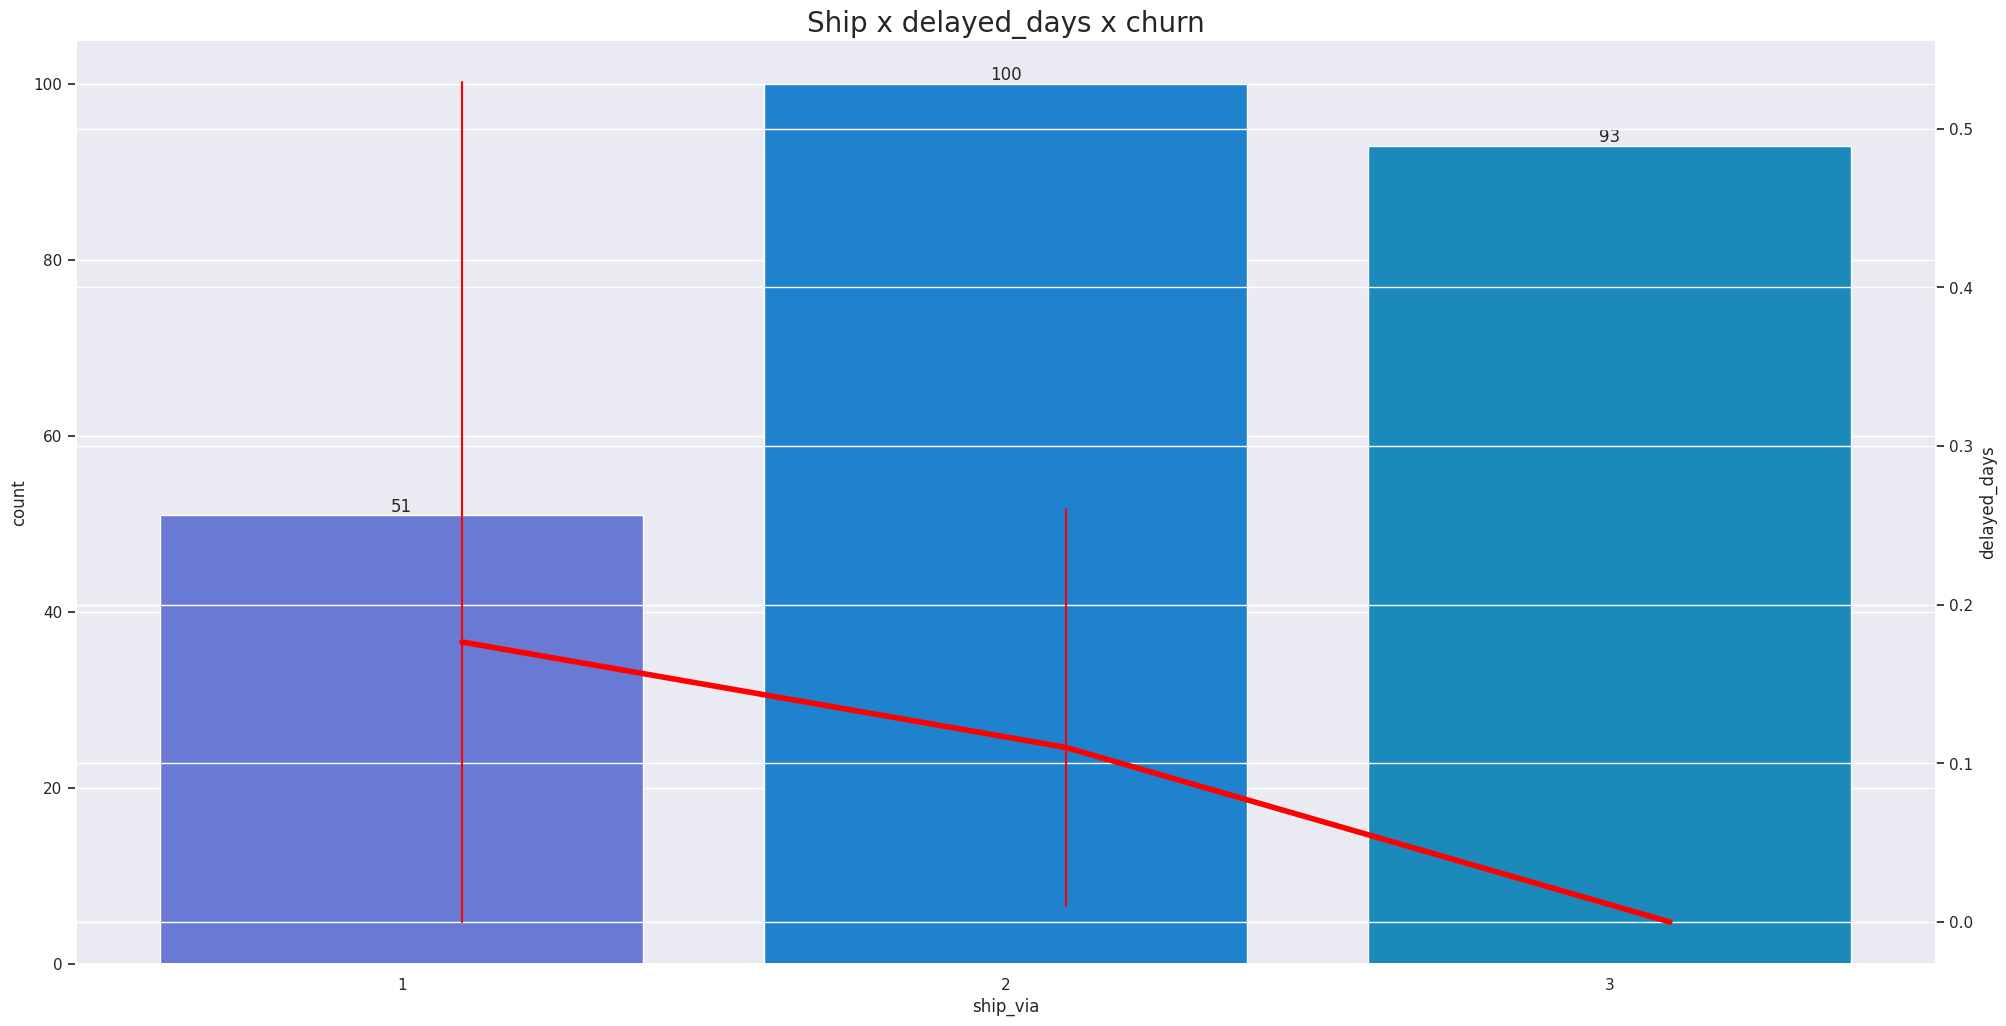

In [41]:
aux = orders_info.copy()
aux['ship_viacopy'] = aux.ship_via -0.9

fig, ax = plt.subplots()
ax_twin = ax.twinx()
bar = sns.countplot(x="ship_via", data=aux.query('churn == True'), ax=ax, palette=["#576EE6", "#0086ED", "#0093D5"])
sns.lineplot(x='ship_viacopy', y='delayed_days', data=aux.query('churn == True'), err_style='bars', ax=ax_twin, color='red', linewidth=4 )
for i in bar.containers:
    bar.bar_label(i,)
plt.title('Ship x delayed_days x churn', fontsize=20)
# plt.title('Churn rate per Ship | AVG delayed_days', fontsize=30)

### <span style="color: lightgreen;"> H5 - Customers in churn buy less ( total purchase ) on median
#### <span style="color: lightgreen;"> True </span> - Customers with higher purchases don't is in churn, but are not too expressive

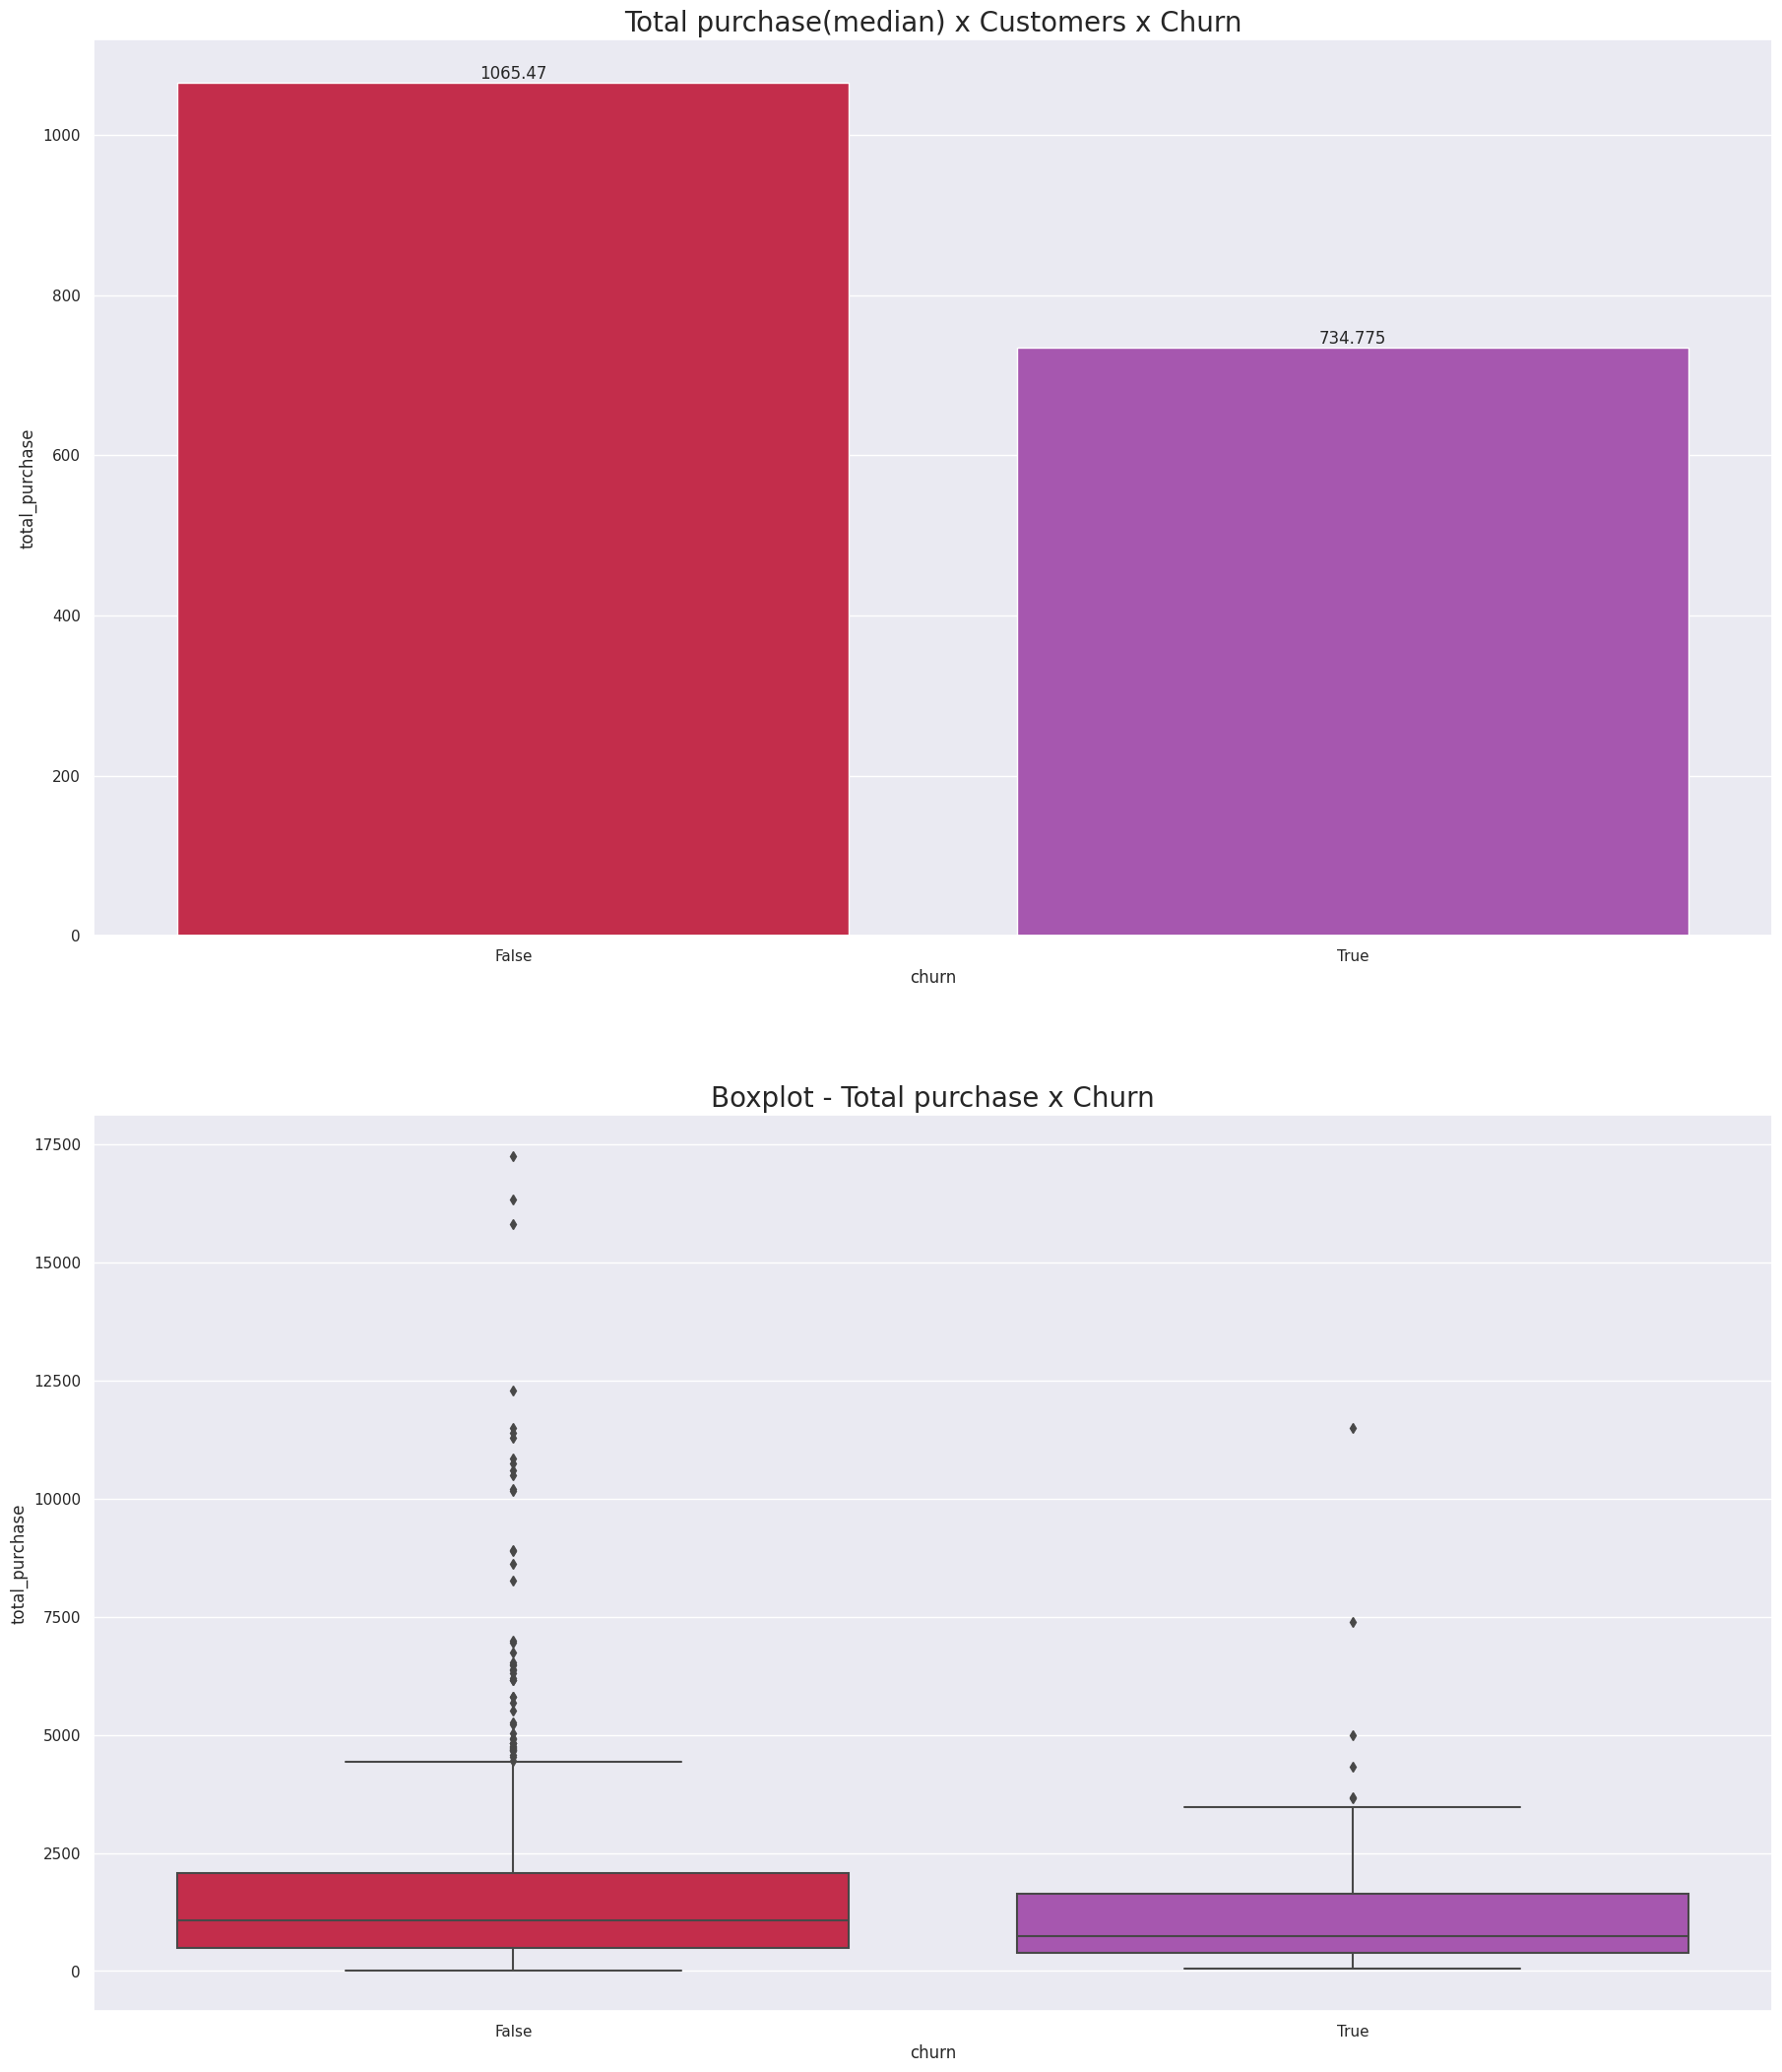

In [42]:
aux = orders_info.copy()
aux = aux.groupby('order_id', as_index=False).first()
aux2 = aux.groupby('churn')[['total_purchase']].median().reset_index()
plt.figure(figsize=(22,26))
plt.subplot( 2, 1, 1)
ax = sns.barplot(data=aux2, y='total_purchase', x='churn');
# plt.ylim(0, 1800)
plt.title('Total purchase(median) x Customers x Churn', fontsize=20)
for i in ax.containers:
    ax.bar_label(i,)

plt.subplot( 2, 1, 2)
sns.boxplot(data=aux, y='total_purchase', x='churn');
plt.title('Boxplot - Total purchase x Churn', fontsize=20);

### <span style="color: lightgreen;"> H6 - Purchases with higher freight, have an influence on churn
#### <span style="color: lightgreen;"> True </span> - Purchases with higher freight, have an influence on churn, but it's because the freight is correlated with the final price

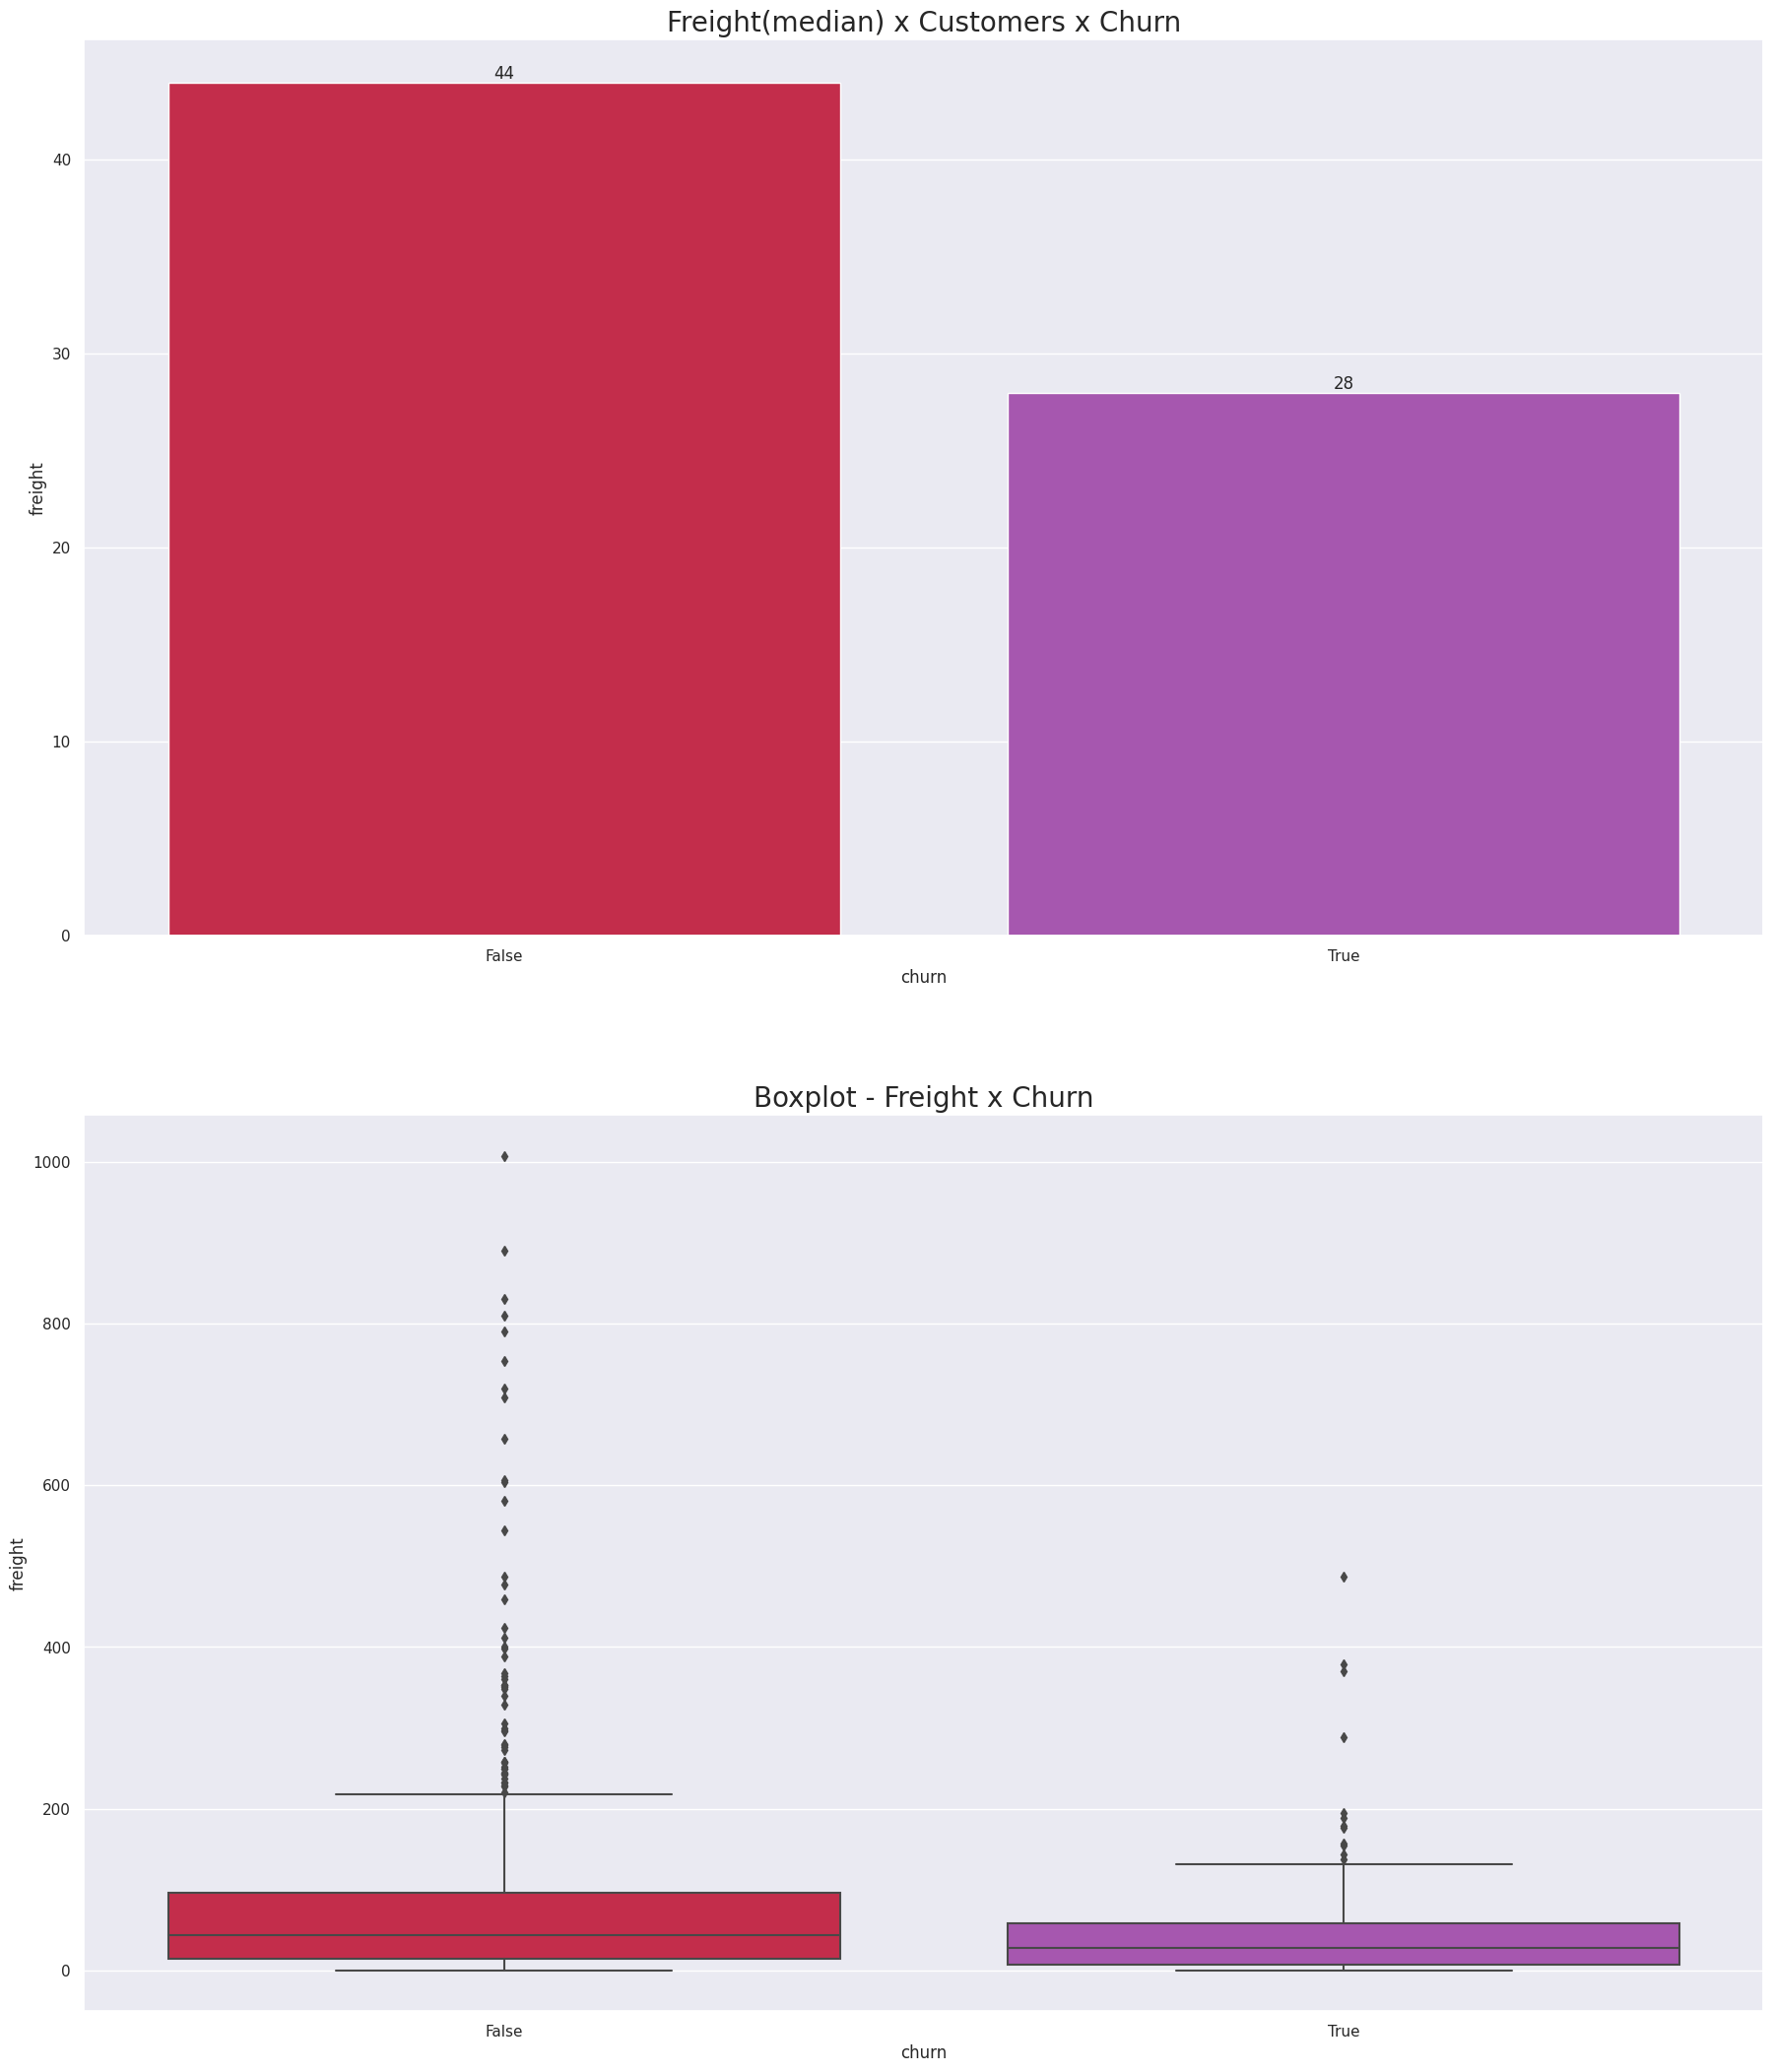

In [43]:
aux = orders_info.copy()
aux = aux.groupby('order_id', as_index=False).first()
aux2 = aux.groupby('churn')[['freight']].median().reset_index().round()
plt.figure(figsize=(22,26))
plt.subplot( 2, 1, 1)
ax = sns.barplot(data=aux2, y='freight', x='churn');

plt.title('Freight(median) x Customers x Churn', fontsize=20)
for i in ax.containers:
    ax.bar_label(i,)

plt.subplot( 2, 1, 2)
sns.boxplot(data=aux, y='freight', x='churn');
plt.title('Boxplot - Freight x Churn', fontsize=20);

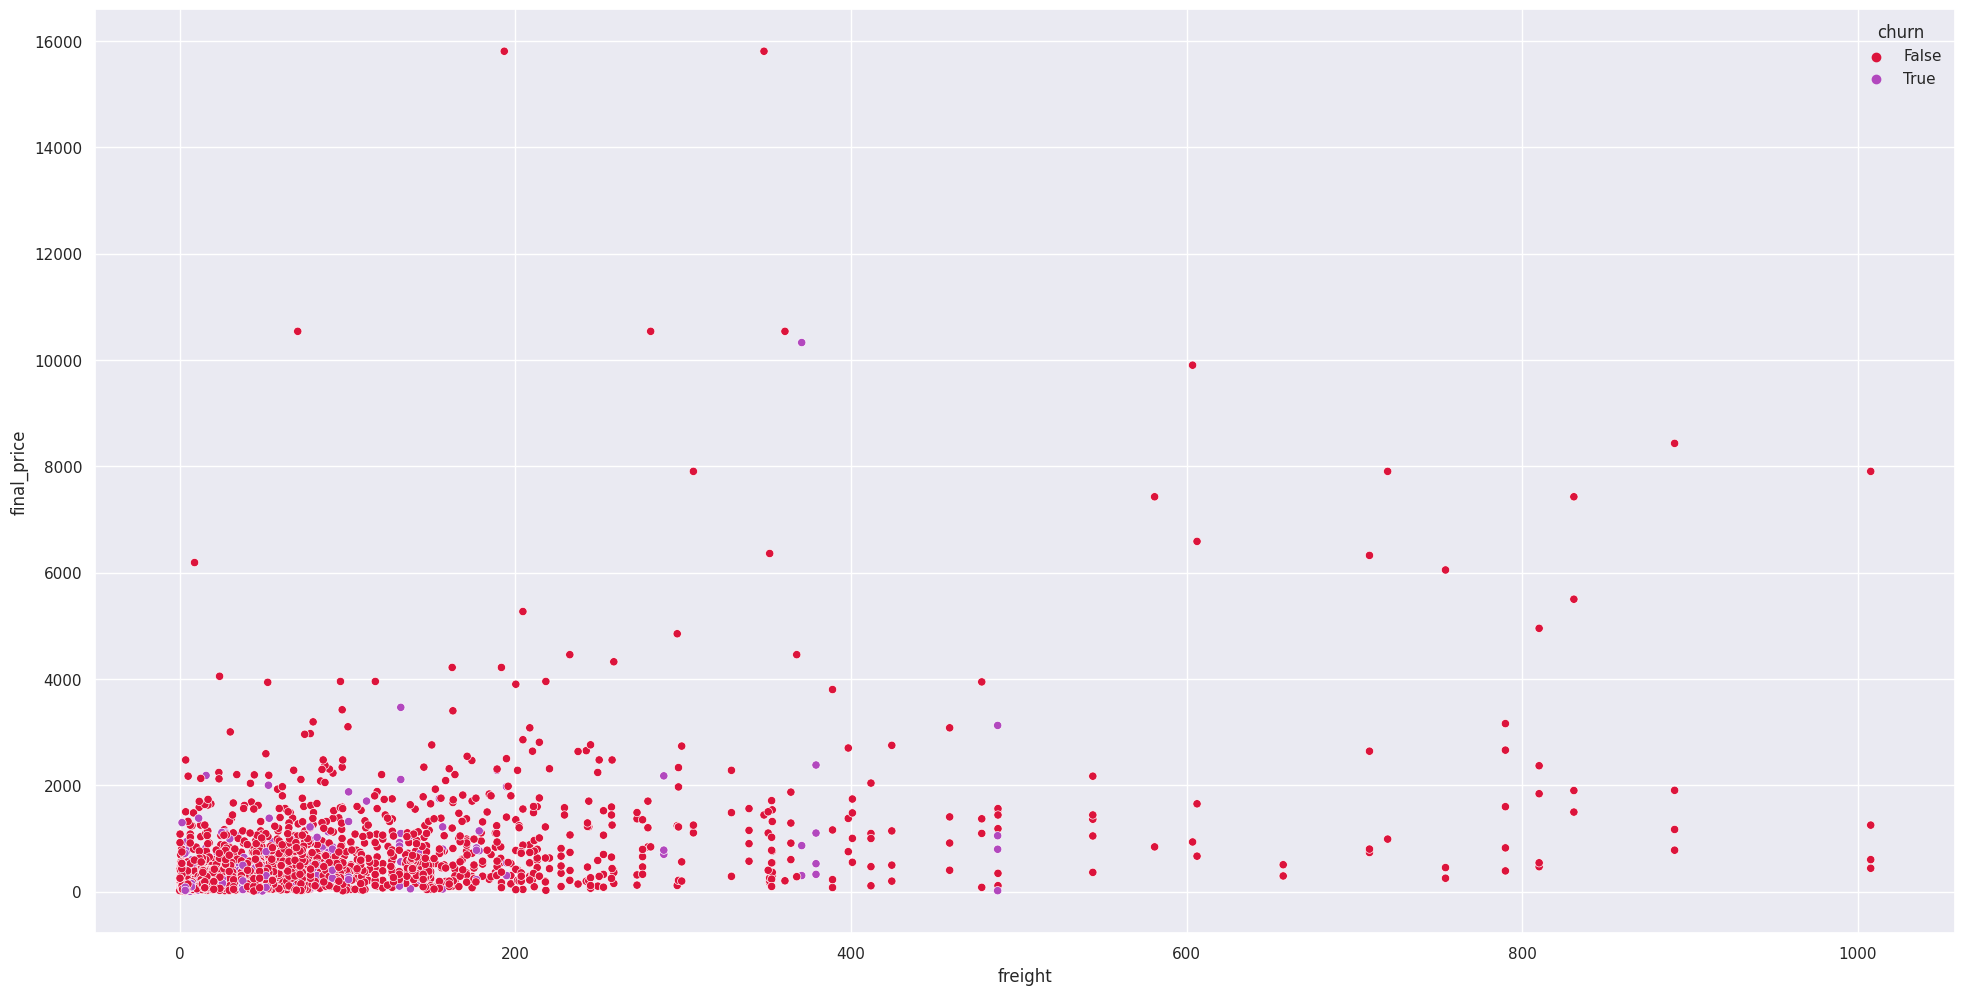

In [44]:
aux2 = orders_info.copy()
sns.scatterplot(data=aux2, x='freight', y='final_price',hue='churn');

### <span style="color: lightgreen;"> H7 - Customers who buy a low number of products are more likely to churn

#### <span style="color: lightgreen;"> True </span> - The smaller the range of products purchased by the customer, the higher the churn rate. NorthWind has only 77 products, this low assortment is one of the causes of churn.

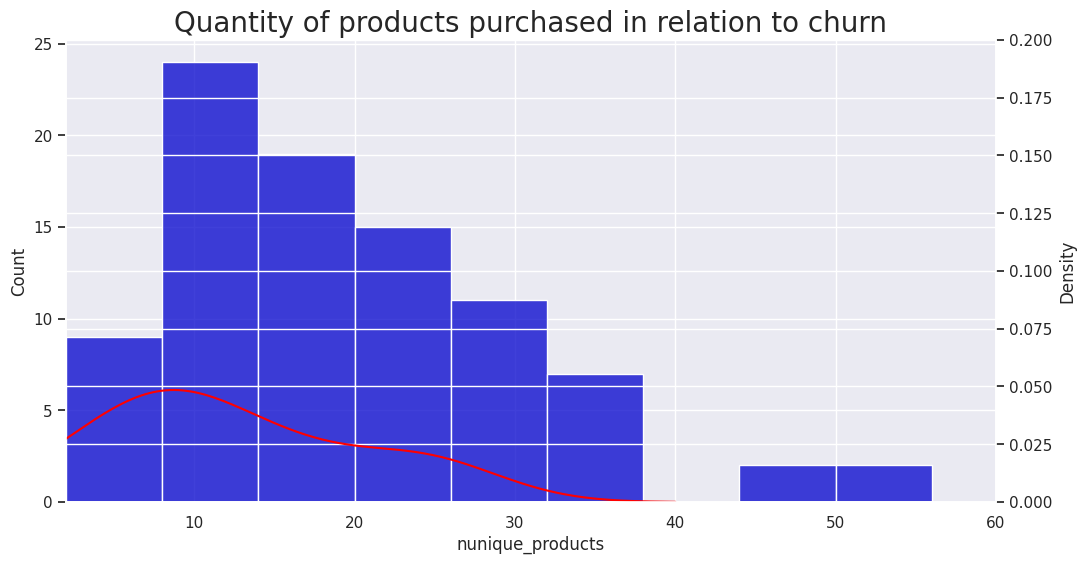

In [45]:
fig, ax1 = plt.subplots(figsize=(12,6))

sns.histplot(data=customer_info, x='nunique_products', ax=ax1, color='mediumblue');
ax2 = ax1.twinx()

sns.kdeplot(data=customer_info.query('churn == True'), x='nunique_products', ax=ax2, color='red')
plt.xlim(2, 60)
plt.ylim(0, 0.2)
plt.title('Quantity of products purchased in relation to churn', fontsize=20);

# 5.0. RFM Analysis

Recência, frequência, valor monetário é uma ferramenta de análise de marketing usada para identificar os melhores clientes de uma empresa ou organização usando determinadas medidas. O modelo RFM é baseado em três fatores quantitativos:

Recência: há quanto tempo um cliente fez uma compra

Frequência: com que frequência um cliente faz uma compra

Valor monetário: quanto dinheiro um cliente gasta em compras


In [46]:
rfm_table = rfm_function(customer_info)
rfm_table.head()

,customer_id,recency,frequency,monetary,R,F,M,RFM_segment,RFM_score,segment
0,ALFKI,27,6,4595.15,3,2,2,322,7,About To Sleep
1,ANATR,63,4,1402.95,2,1,1,211,4,Hibernating
2,ANTON,98,7,7514.35,1,2,3,123,6,Hibernating
3,AROUT,26,13,13805.80,3,4,4,344,11,Loyal Customers
4,BERGS,63,18,26965.15,2,5,5,255,12,Cannot lose them


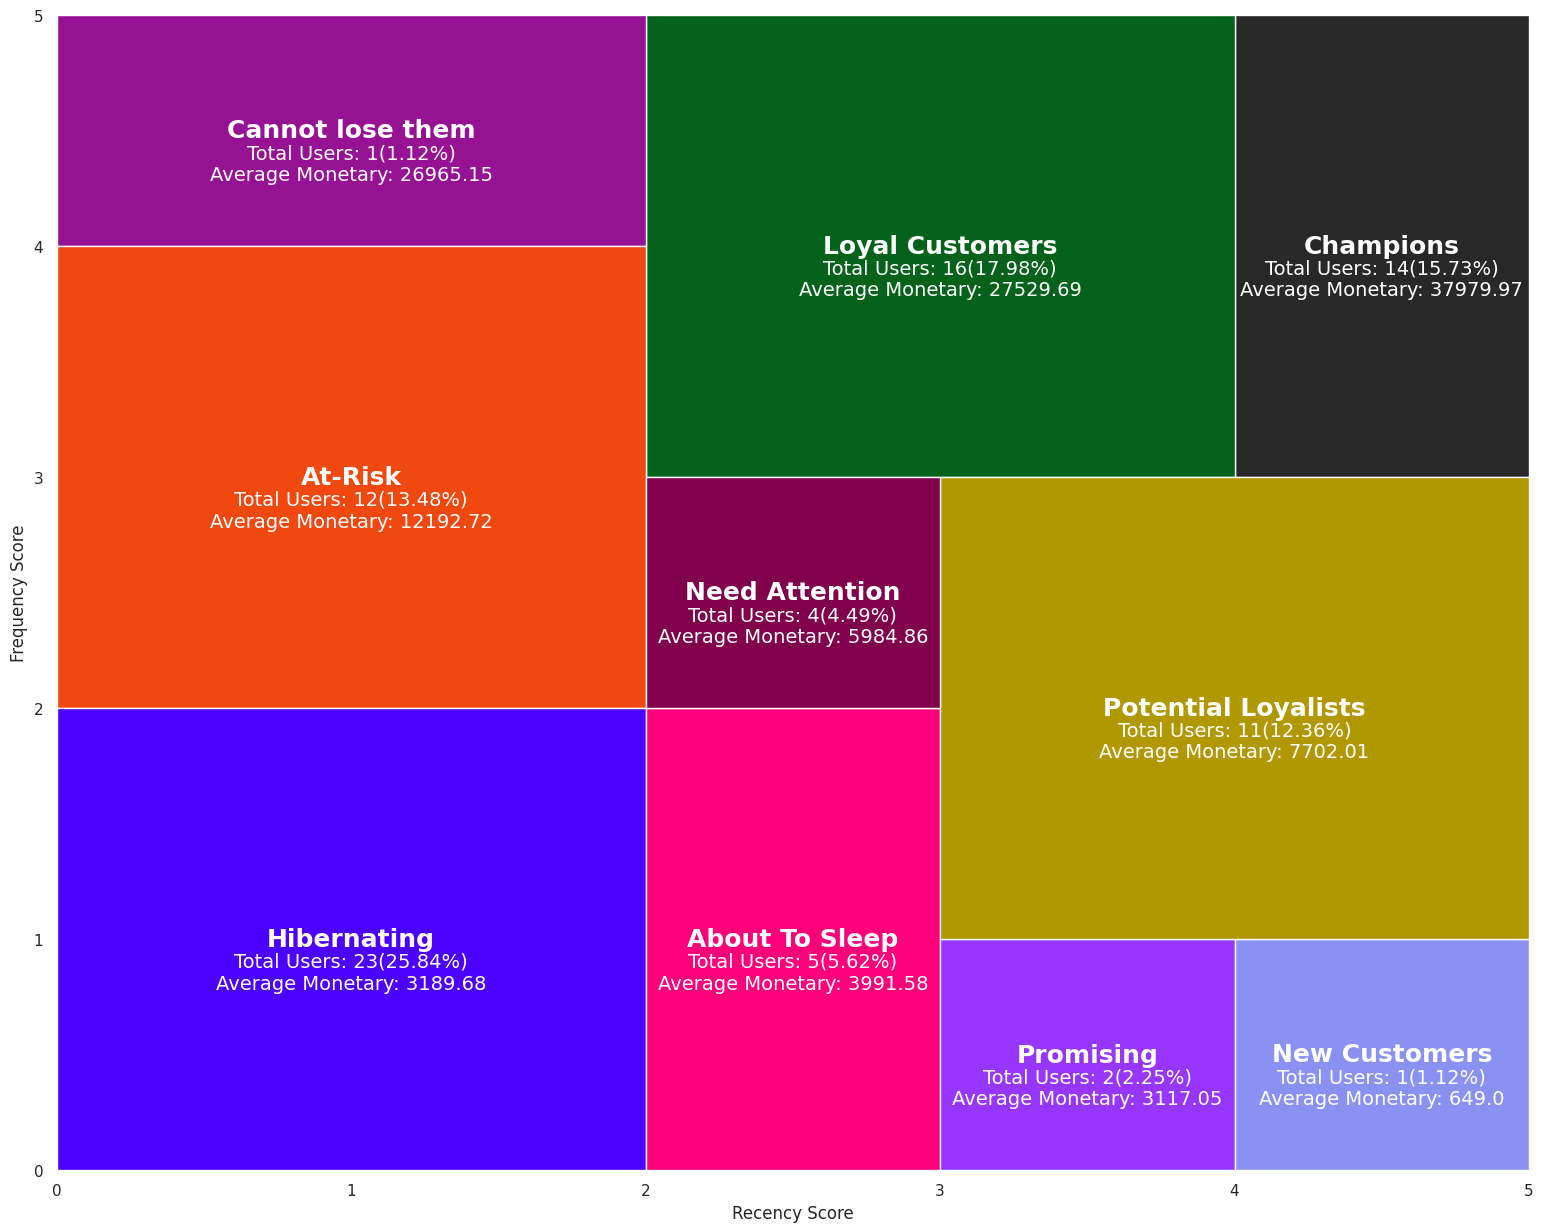

In [47]:
plot_rfm(rfm_table)

Os grupos do canto superior esquerdo, em especial o **“Cannot lose them”**  são clientes que gastaram um alto valor, mas estão entrando em churn. Esses clientes precisam de uma atenção especial, novos descontos ou reduzir o valor de frete podem ser uma ótima medida.

Já os grupos do canto inferior direito e em especial o **“Potential Loyalists”** são clientes que tem um alto potencial, utilizar o sistema de recomendação para esses grupos pode fazer com que comprem novos tipos de produtos e aumentem o ticket médio.


# 6.0. Recommendation System ( Average ticket problem )

## 6.1. Get the customer behavior

In [48]:
customer_behavior = orders_info.copy()
# split order category
customer_behavior[['Beverages', 'Condiments', 'Confections', 'Dairy Products',
               'Grains/Cereals', 'Meat/Poultry', 'Produce', 'Seafood']] = pd.get_dummies(orders_info.category_name)

customer_behavior.head()

,order_id,customer_id,order_date,required_date,shipped_date,first_purchase,delayed_days,avg_delayed_days,ship_via,freight,product_id,unit_price_x,quantity,discount,final_price,units_in_stock,units_on_order,reorder_level,discontinued,category_name,churn,total_purchase,order_year,order_month,order_day,order_day_week,Beverages,Condiments,Confections,Dairy Products,Grains/Cereals,Meat/Poultry,Produce,Seafood
0,10248,VINET,1996-07-04,1996-08-01,1996-07-16,1996-07-04,0.0,0.0,3,32.38,11,14.0,12,0.0,168.0,22,30,30,0,Dairy Products,True,440.0,1996,7,4,3,0,0,0,1,0,0,0,0
1,10248,VINET,1996-07-04,1996-08-01,1996-07-16,1996-07-04,0.0,0.0,3,32.38,42,9.8,10,0.0,98.0,26,0,0,1,Grains/Cereals,True,440.0,1996,7,4,3,0,0,0,0,1,0,0,0
2,10248,VINET,1996-07-04,1996-08-01,1996-07-16,1996-07-04,0.0,0.0,3,32.38,72,34.8,5,0.0,174.0,14,0,0,0,Dairy Products,True,440.0,1996,7,4,3,0,0,0,1,0,0,0,0
3,10274,VINET,1996-08-06,1996-09-03,1996-08-16,1996-07-04,0.0,0.0,1,6.01,72,27.8,7,0.0,194.6,14,0,0,0,Dairy Products,True,538.6,1996,8,6,1,0,0,0,1,0,0,0,0
4,10274,VINET,1996-08-06,1996-09-03,1996-08-16,1996-07-04,0.0,0.0,1,6.01,71,17.2,20,0.0,344.0,26,0,0,0,Dairy Products,True,538.6,1996,8,6,1,0,0,0,1,0,0,0,0


In [49]:
# Select the customer and the category of customers purchase
customer_behavior = customer_behavior[['customer_id', 'Beverages', 'Condiments', 'Confections', 'Dairy Products', 'Grains/Cereals', 'Meat/Poultry', 'Produce', 'Seafood']]

# group customers and get the mean of purchase behavior
customer_behavior = customer_behavior.groupby('customer_id').mean().reset_index()

# calculate the total of behavior purchase
customer_behavior['total'] = customer_behavior['Beverages'] + customer_behavior['Condiments'] + customer_behavior['Confections'] + customer_behavior['Dairy Products'] + customer_behavior['Grains/Cereals'] + customer_behavior['Meat/Poultry'] + customer_behavior['Produce'] + customer_behavior['Seafood']

customer_behavior.head()

,customer_id,Beverages,Condiments,Confections,Dairy Products,Grains/Cereals,Meat/Poultry,Produce,Seafood,total
0,ALFKI,0.166667,0.333333,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,1.0
1,ANATR,0.100000,0.000000,0.100000,0.500000,0.100000,0.000000,0.100000,0.100000,1.0
2,ANTON,0.235294,0.058824,0.117647,0.294118,0.117647,0.117647,0.000000,0.058824,1.0
3,AROUT,0.200000,0.000000,0.166667,0.166667,0.200000,0.066667,0.033333,0.166667,1.0
4,BERGS,0.250000,0.076923,0.153846,0.115385,0.019231,0.134615,0.057692,0.192308,1.0


In [50]:
# adding the contry and firts time purchase
customer_behavior = customer_behavior.merge(customer_info[['customer_id', 'country', 'first_purchase']])
customer_behavior.head()

,customer_id,Beverages,Condiments,Confections,Dairy Products,Grains/Cereals,Meat/Poultry,Produce,Seafood,total,country,first_purchase
0,ALFKI,0.166667,0.333333,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,1.0,Germany,1997-08-25
1,ANATR,0.100000,0.000000,0.100000,0.500000,0.100000,0.000000,0.100000,0.100000,1.0,Mexico,1996-09-18
2,ANTON,0.235294,0.058824,0.117647,0.294118,0.117647,0.117647,0.000000,0.058824,1.0,Mexico,1996-11-27
3,AROUT,0.200000,0.000000,0.166667,0.166667,0.200000,0.066667,0.033333,0.166667,1.0,UK,1996-11-15
4,BERGS,0.250000,0.076923,0.153846,0.115385,0.019231,0.134615,0.057692,0.192308,1.0,Sweden,1996-08-12


In [51]:
# Grouping countries by continent

NA = ['Mexico', 'USA',  'Canada']

EU = ['Sweden', 'Switzerland', 'Italy', 'Germany', 'Spain', 'Belgium', 
      'Ireland', 'Norway', 'Denmark','Finland','Austria','France','Poland']

SA = ['Brazil',  'Venezuela',  'Argentina','Portugal', 'UK']

In [52]:
customer_behavior['NA'] = customer_behavior.country.isin(NA).astype(int)
customer_behavior['EU'] = customer_behavior.country.isin(EU).astype(int)
customer_behavior['SA'] = customer_behavior.country.isin(SA).astype(int)


In [53]:
customer_behavior = customer_behavior[['customer_id', 'Beverages', 'Condiments', 'Confections', 'Dairy Products', 
                                       'Grains/Cereals', 'Meat/Poultry', 'Produce', 'Seafood', 'total', 'NA', 'EU', 'SA']]
customer_behavior.head()

,customer_id,Beverages,Condiments,Confections,Dairy Products,Grains/Cereals,Meat/Poultry,Produce,Seafood,total,NA,EU,SA
0,ALFKI,0.166667,0.333333,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,1.0,0,1,0
1,ANATR,0.100000,0.000000,0.100000,0.500000,0.100000,0.000000,0.100000,0.100000,1.0,1,0,0
2,ANTON,0.235294,0.058824,0.117647,0.294118,0.117647,0.117647,0.000000,0.058824,1.0,1,0,0
3,AROUT,0.200000,0.000000,0.166667,0.166667,0.200000,0.066667,0.033333,0.166667,1.0,0,0,1
4,BERGS,0.250000,0.076923,0.153846,0.115385,0.019231,0.134615,0.057692,0.192308,1.0,0,1,0


## 6.2. Clustering the customer behavior

In [54]:
train = customer_behavior[['Beverages', 'Condiments', 'Confections',
       'Dairy Products', 'Grains/Cereals', 'Meat/Poultry', 'Produce',
       'Seafood', 'NA', 'EU', 'SA']]

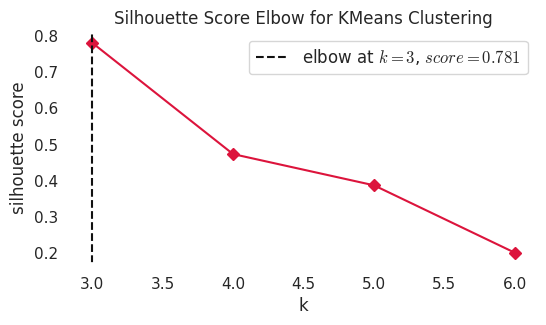

In [55]:
clusters = [3, 4, 5, 6]
plt.figure(figsize = (6,3));
kmeans_viz = KElbowVisualizer(KMeans(n_init=10, random_state=0), k=clusters, metric='silhouette', timings=False );
kmeans_viz.fit(train);
kmeans_viz.show();

In [56]:
kmeans = KMeans( n_clusters=3, #número de clusters
                  n_init=10, #número de vezes que o k-means irá com diferentes centroid seeds
                 random_state=0) #seed, para gerar a mesma inicialização aleatória
kmeans.fit(train)
labels_kmeans = kmeans.labels_
labels_kmeans[:5]

array([1, 2, 2, 0, 1], dtype=int32)

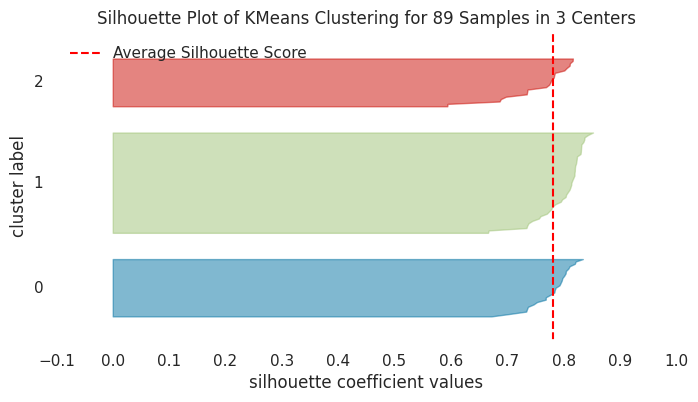

In [57]:
plt.figure(figsize = (8,4));
model = KMeans(3, random_state=42, n_init='auto')
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(train) 
visualizer.show();

Considerações:
Não há pontos com valores negativos, se houvesse pontos com valores negativos, deveriam pertencer a outros clusters.

Quanto mais quadrada a ponta direita do shape for, mais condensado e distante dos outros ele está, logo melhor é a qualidade daquele cluster.

## 6.3. Cluster Analysis

In [58]:
customer_behavior['cluster'] = labels_kmeans

In [59]:
cluster = customer_behavior[['customer_id', 'Beverages', 'Condiments', 'Confections',
       'Dairy Products', 'Grains/Cereals', 'Meat/Poultry', 'Produce',
       'Seafood', 'NA', 'EU', 'SA', 'cluster']]

In [60]:
cluster0 = cluster.drop(columns=['customer_id'])

### 6.3.1. South America


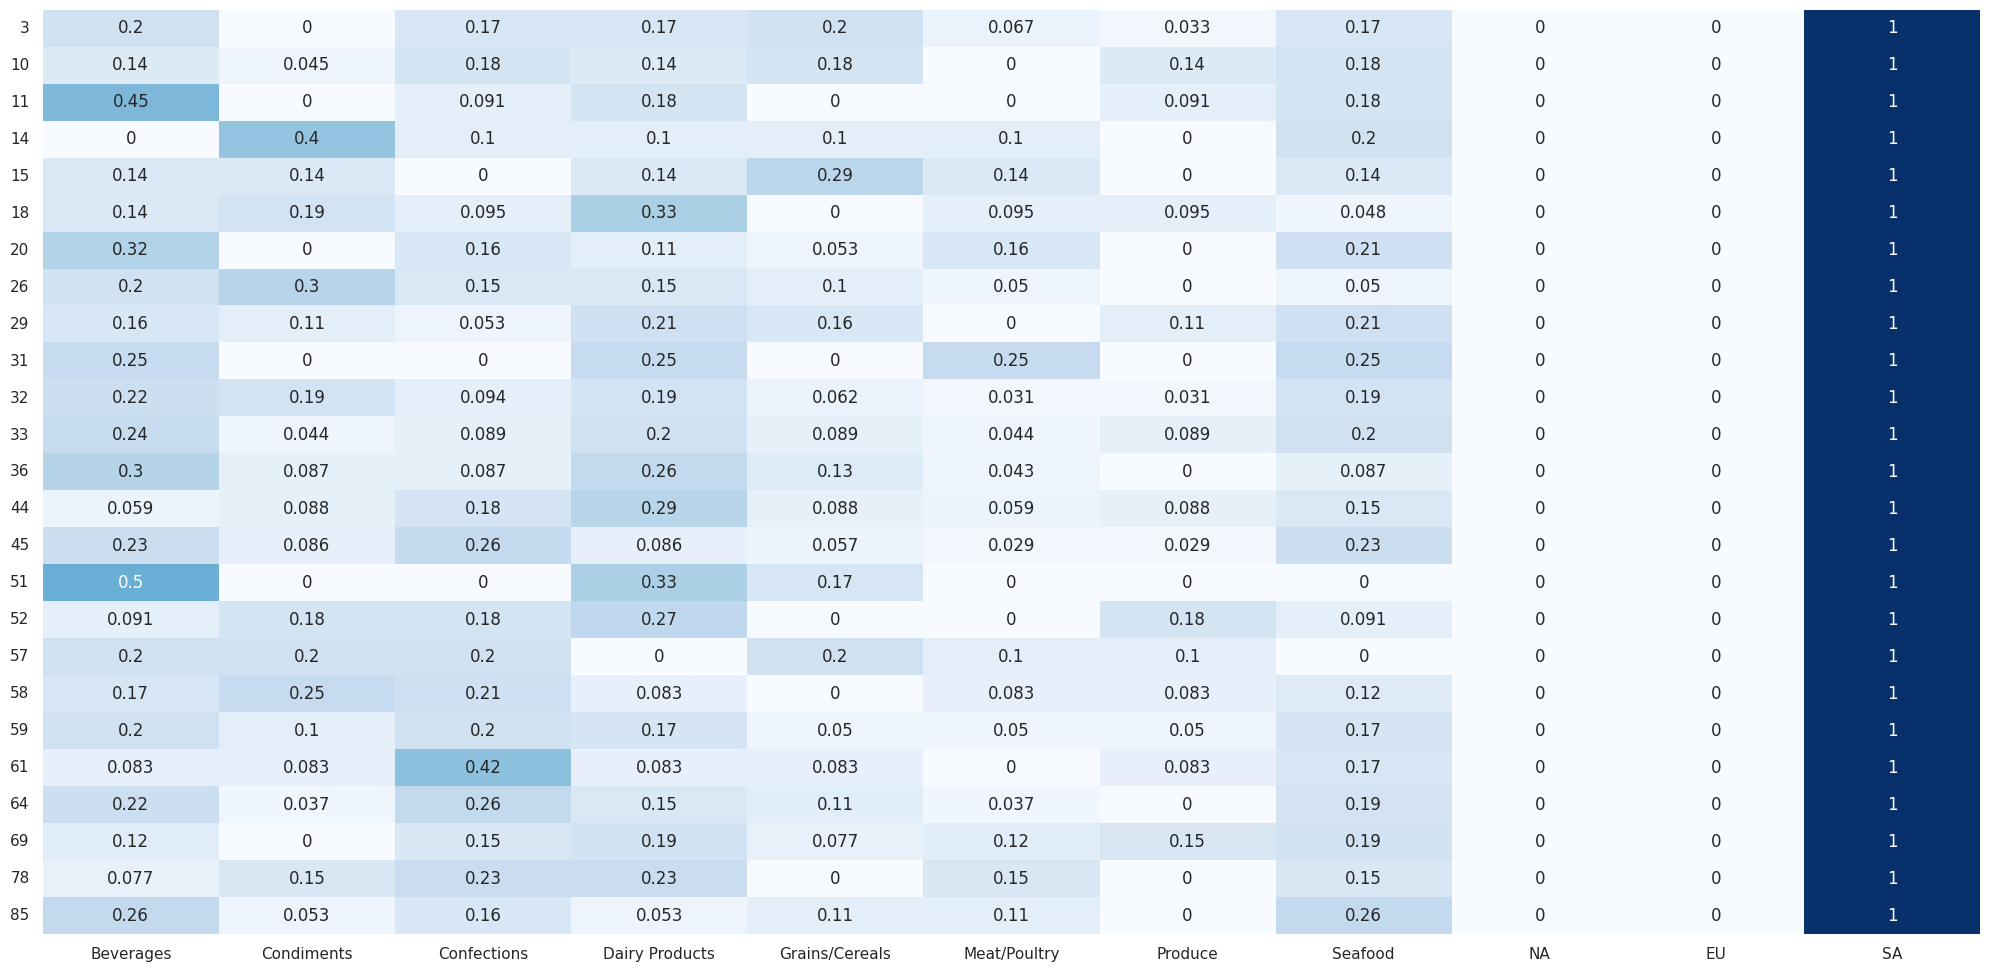

In [61]:
heatmap_cluster(cluster0, '0')

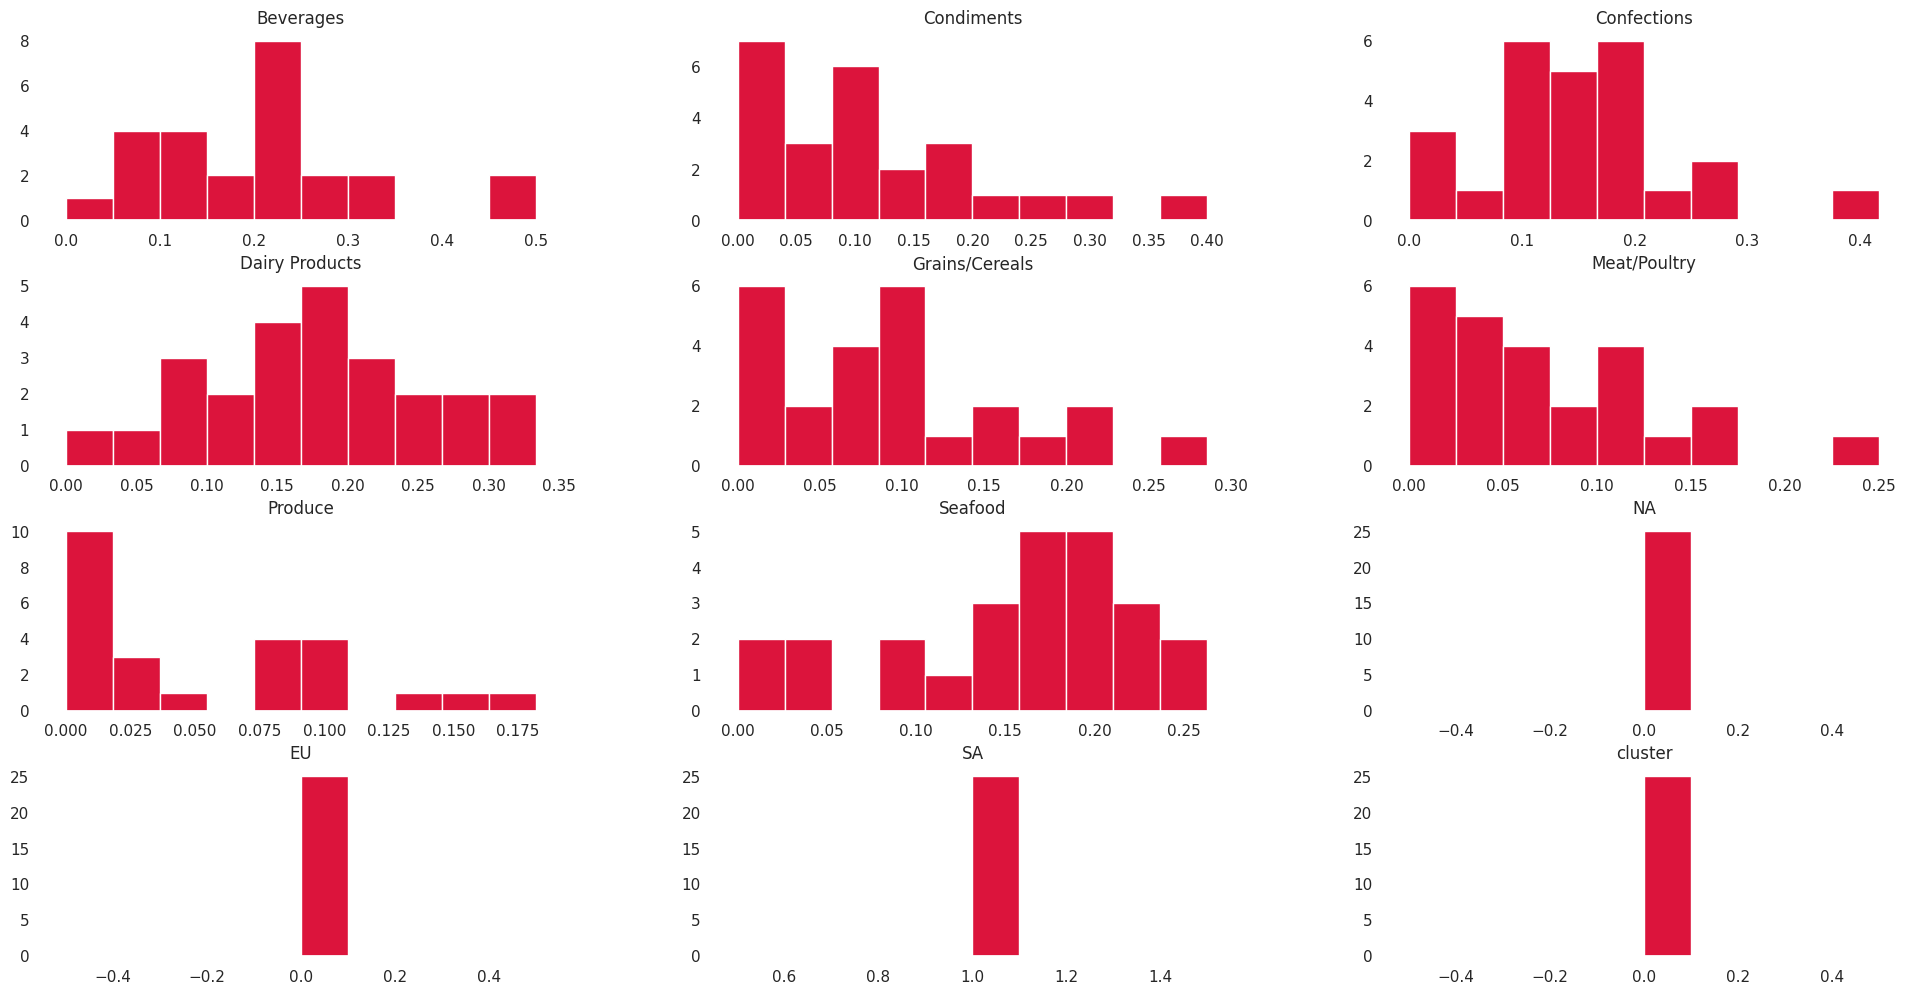

In [62]:
cluster0.query('cluster == 0').hist();

#### In the South American customer cluster, customers tend to buy more products from the 'Seafood' category and less from the 'Condiments' and 'Grains/Cereals' categories.

### 6.3.2. Europe

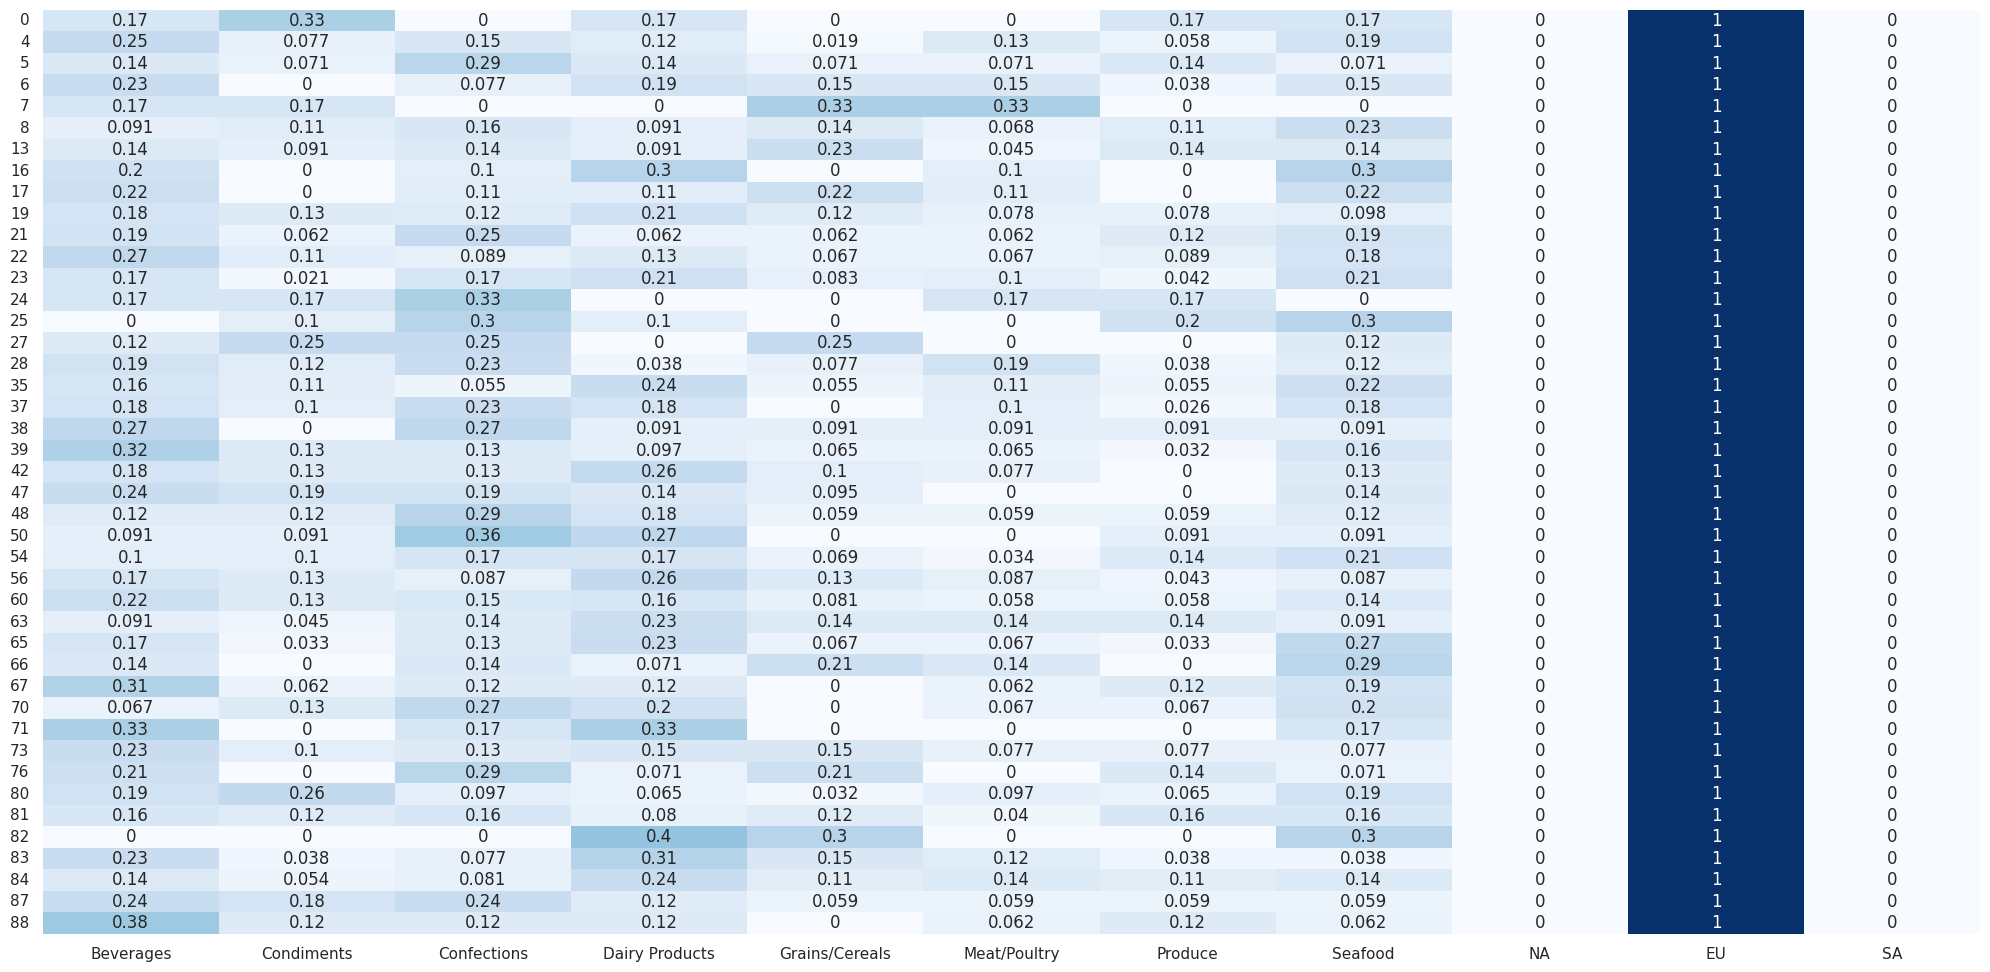

In [63]:
heatmap_cluster(cluster0, '1')

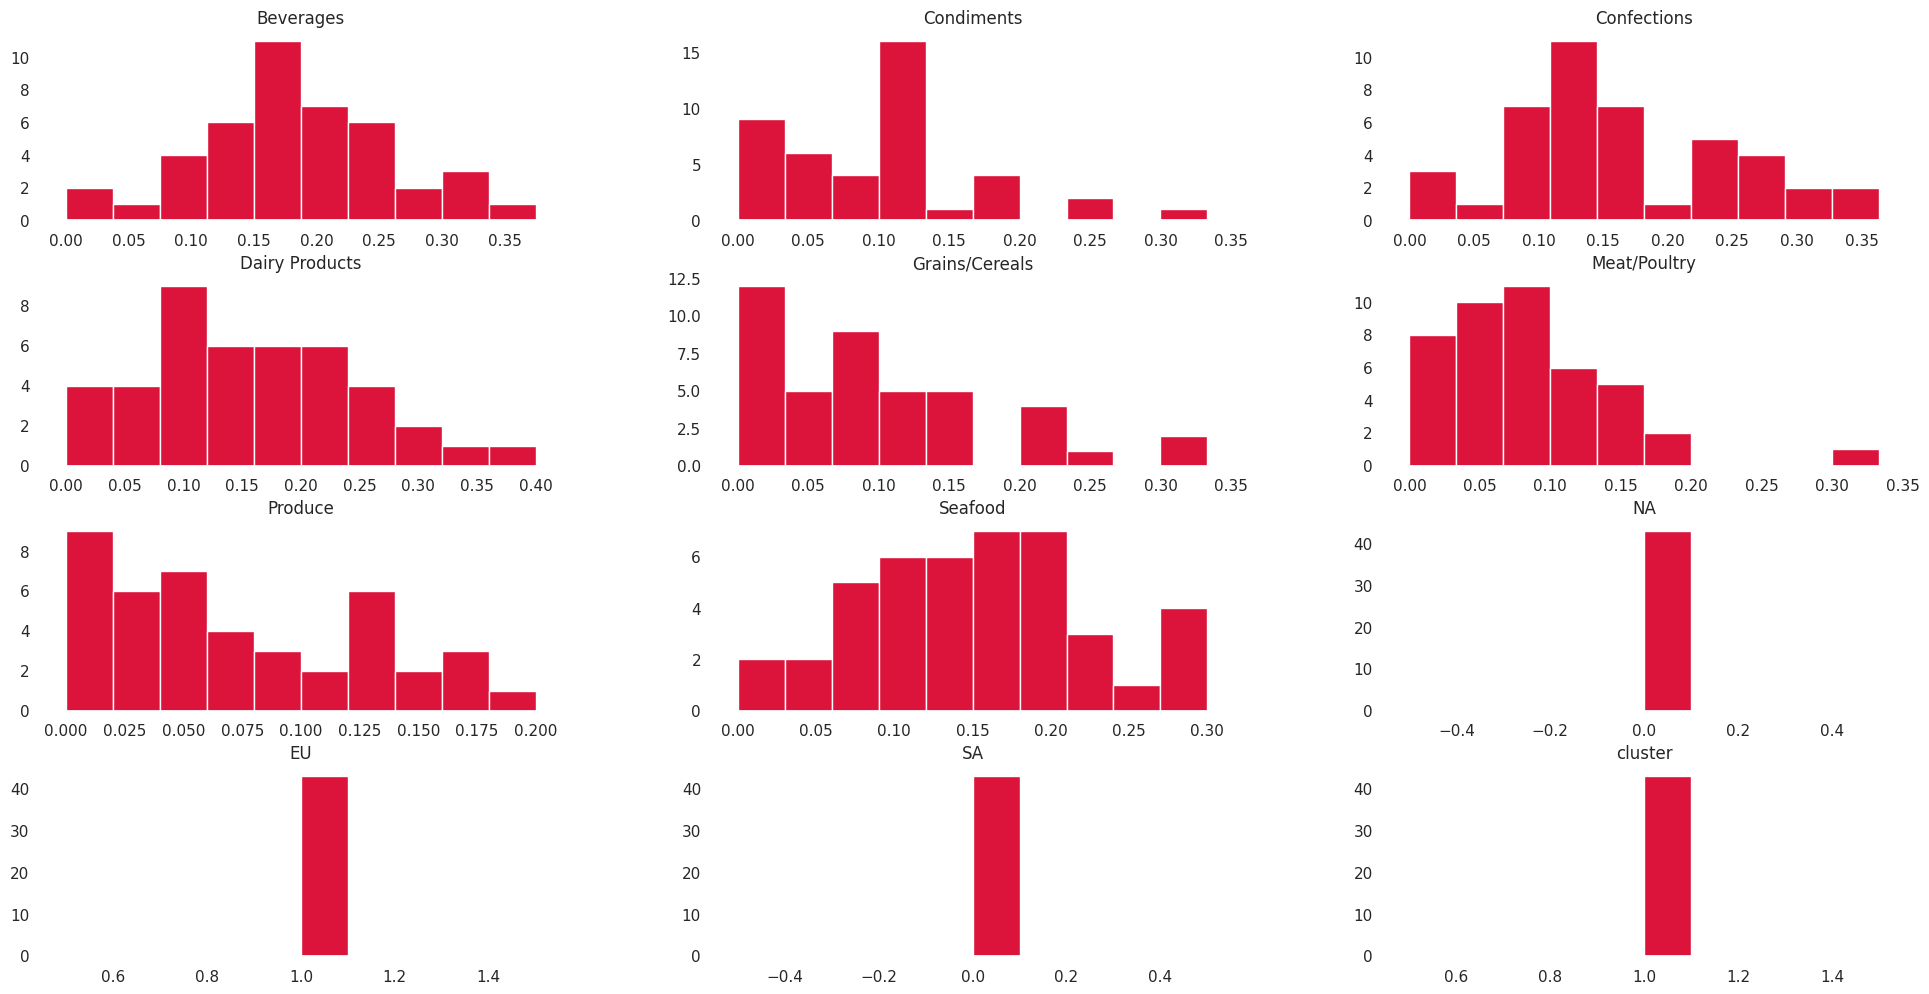

In [64]:
cluster0.query('cluster == 1').hist();

#### In the European customer cluster, they tend to buy less in the 'Produce' and 'Meat/Poultry' category, while in the other categories, they are well balanced.

### 6.3.3. North America

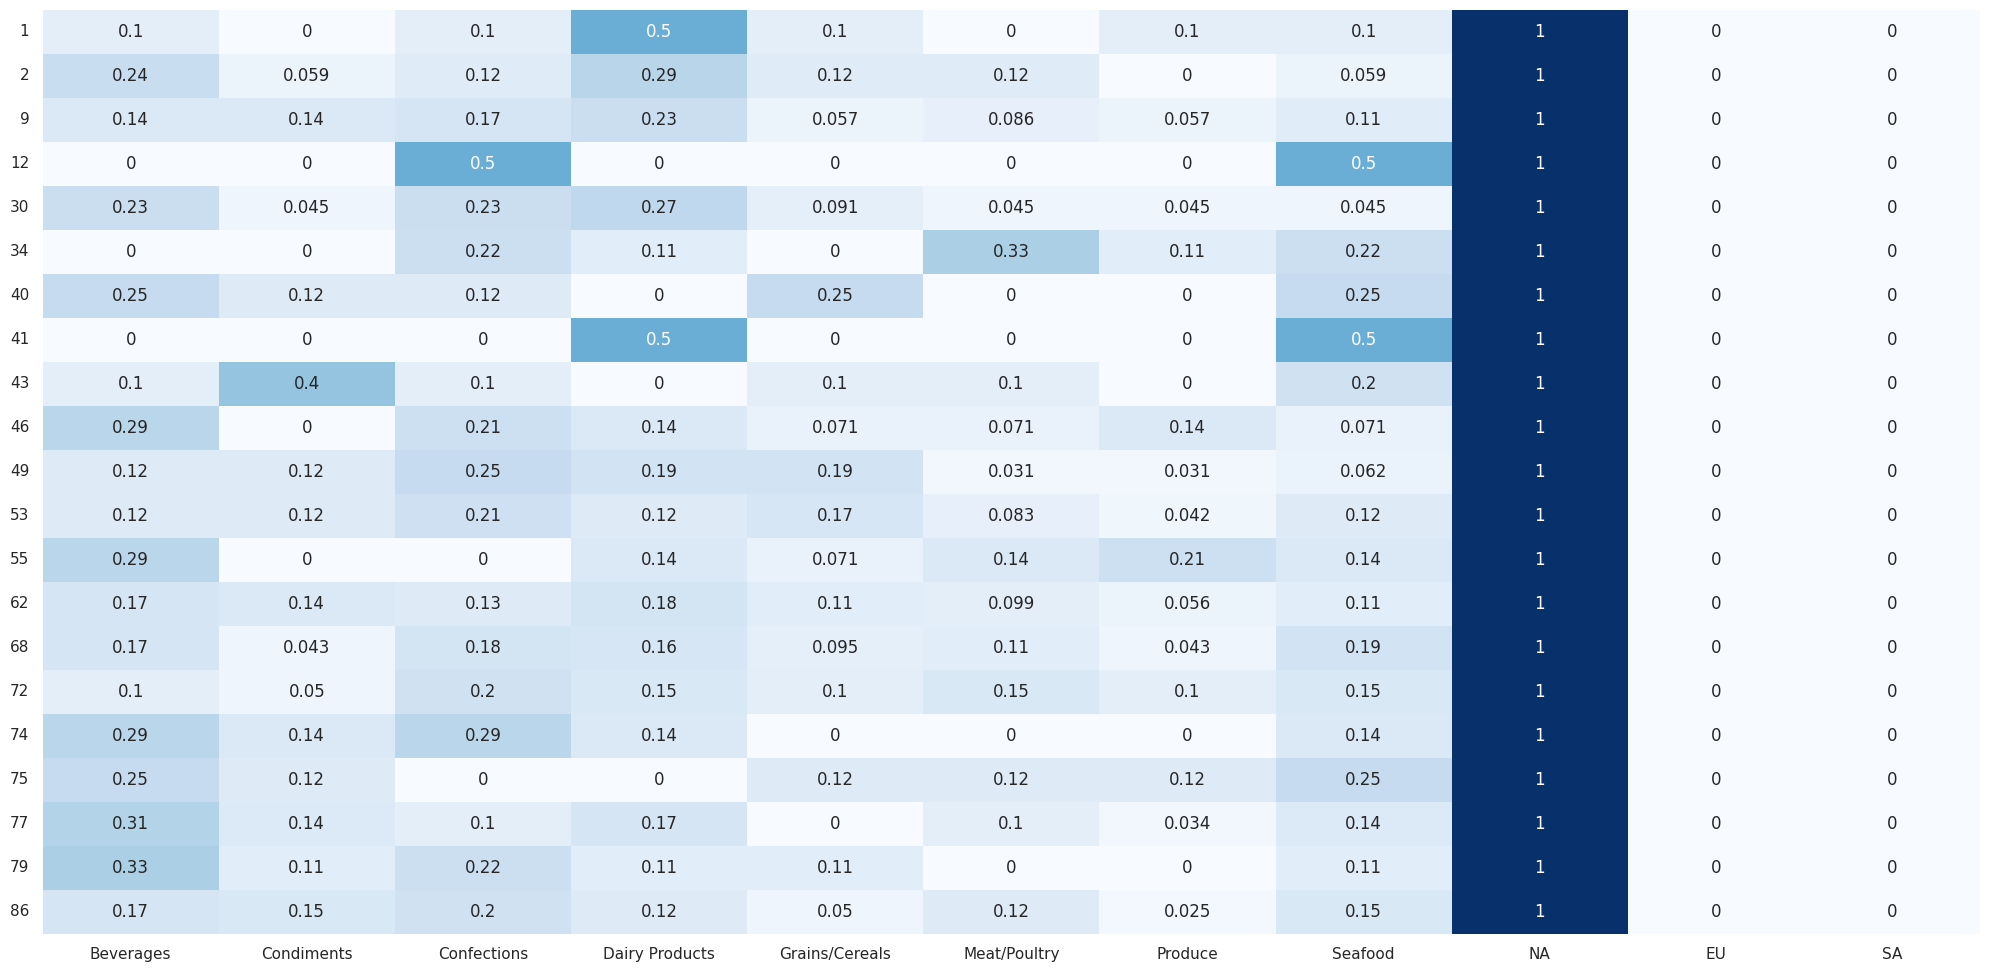

In [65]:
heatmap_cluster(cluster0, '2')

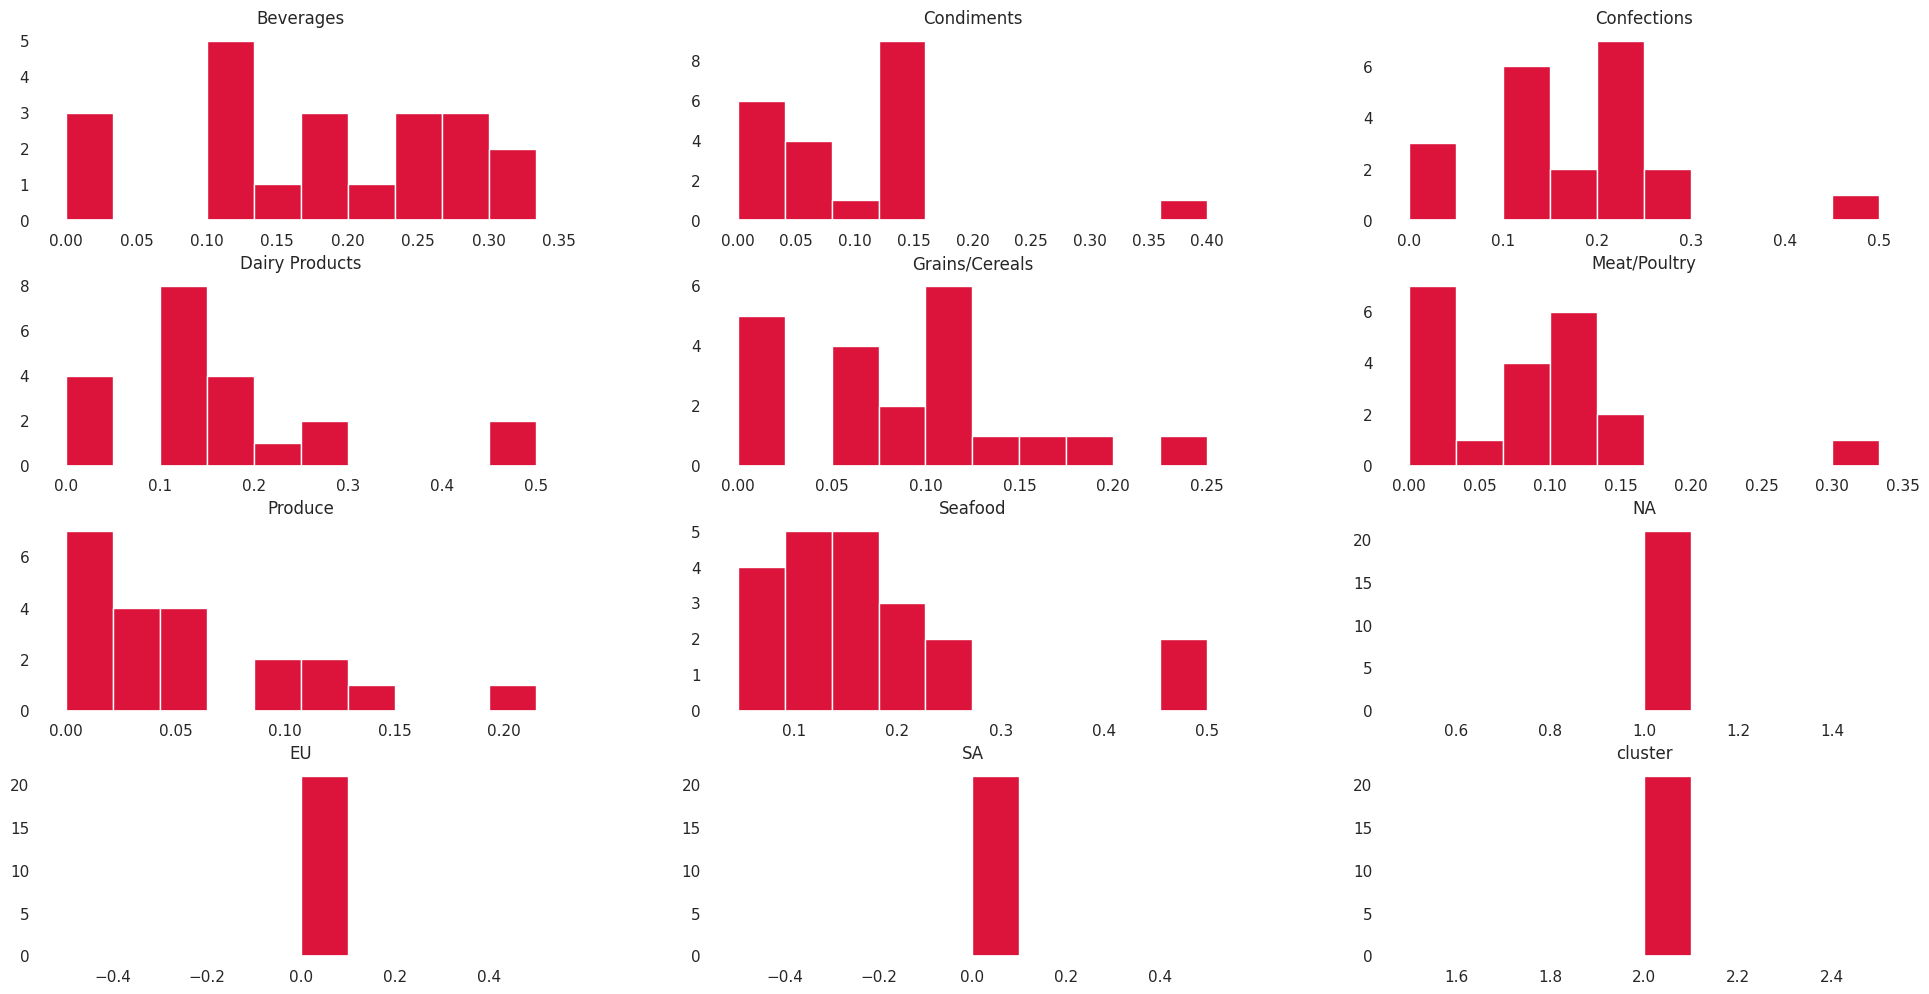

In [66]:
cluster0.query('cluster == 2').hist();

#### In the North America customer cluster, customers tend to buy more products from the 'Beverages' category and less from the 'Meat/Poultry' and 'Seafood' categories.

## 6.4. System recommendation

In [67]:
cluster.cluster.unique()

array([1, 2, 0], dtype=int32)

In [68]:
customer_info = customer_info.merge(cluster[['customer_id', 'cluster']], on='customer_id')

In [69]:
cluster_dict = {0: 'SA', 1:'EU', 2:'NA'}

In [70]:
customer_info.cluster = customer_info.cluster.map(cluster_dict)

In [71]:
customer_info.head()

,customer_id,company_name,country,first_purchase,last_purchase,customer_lifetime,avg_time_between_purchase,time_to_last_purchase,avg_delayed_days,num_purchases,nunique_products,nunique_product_rate,total_payment_volume,average_ticket,churn,cluster
0,ALFKI,Alfreds Futterkiste,Germany,1997-08-25,1998-04-09,227,37,27,0.000000,6,11,0.14,4595.15,765.86,False,EU
1,ANATR,Ana Trujillo Emparedados y helados,Mexico,1996-09-18,1998-03-04,532,133,63,0.000000,4,10,0.13,1402.95,350.74,False,NA
2,ANTON,Antonio Moreno Taquería,Mexico,1996-11-27,1998-01-28,427,61,98,0.000000,7,15,0.19,7514.35,1073.48,True,NA
3,AROUT,Around the Horn,UK,1996-11-15,1998-04-10,511,39,26,0.000000,13,24,0.31,13805.80,1061.98,False,SA
4,BERGS,Berglunds snabbköp,Sweden,1996-08-12,1998-03-04,569,31,63,0.461538,18,37,0.48,26965.15,1498.06,False,EU


In [72]:
def recomendation_system(cluster, customer_id,data,products):
    # make a matrix with the proximity of the points
    sys = pd.DataFrame(1 - squareform(pdist(cluster.set_index('customer_id'), lambda u,v: (u != v).mean())), index=cluster.customer_id.values)
    
    # Rename the columns with customer_id
    sys.columns = cluster.customer_id.values
    
    # get the customer with more similarity
    similar_customer = sys[customer_id].sort_values().index[-2]
    
    #
    similarity = sys[customer_id].sort_values()[-2]
    
    print(f'A customer {customer_id} é similar ao customer {similar_customer} com pontuação de: {similarity}')
    print('\nA lista de produtos recomendados para este customer é:')
    
    product_list = (data.query("customer_id == @similar_customer").product_id.unique())
    recomended_products = products.loc[products.product_id.isin(product_list)]
    
    return recomended_products

In [73]:
recomendation_system(cluster, 'BERGS',data,products)

A customer BERGS é similar ao customer WOLZA com pontuação de: 0.33333333333333337

A lista de produtos recomendados para este customer é:


,product_id,product_name,supplier_id,category_id,quantity_per_unit,unit_price,units_in_stock,units_on_order,reorder_level,discontinued
0,1,Chai,8,1,10 boxes x 30 bags,18.00,39,0,10,1
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,1
23,24,Guaraná Fantástica,10,1,12 - 355 ml cans,4.50,20,0,0,1
30,31,Gorgonzola Telino,14,4,12 - 100 g pkgs,12.50,0,70,20,0
34,35,Steeleye Stout,16,1,24 - 12 oz bottles,18.00,20,0,15,0
50,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0
53,54,Tourtière,25,6,16 pies,7.45,21,0,10,0
57,58,Escargots de Bourgogne,27,8,24 pieces,13.25,62,0,20,0
59,60,Camembert Pierrot,28,4,15 - 300 g rounds,34.00,19,0,0,0
60,61,Sirop d'érable,29,2,24 - 500 ml bottles,28.50,113,0,25,0


In [74]:
recomendation_system(cluster, 'AROUT',data,products)

A customer AROUT é similar ao customer PRINI com pontuação de: 0.5

A lista de produtos recomendados para este customer é:


,product_id,product_name,supplier_id,category_id,quantity_per_unit,unit_price,units_in_stock,units_on_order,reorder_level,discontinued
0,1,Chai,8,1,10 boxes x 30 bags,18.00,39,0,10,1
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
7,8,Northwoods Cranberry Sauce,3,2,12 - 12 oz jars,40.00,6,0,0,0
20,21,Sir Rodney's Scones,8,3,24 pkgs. x 4 pieces,10.00,3,40,5,0
28,29,Thüringer Rostbratwurst,12,6,50 bags x 30 sausgs.,123.79,0,0,0,1
38,39,Chartreuse verte,18,1,750 cc per bottle,18.00,69,0,5,0
41,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1
50,51,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0
55,56,Gnocchi di nonna Alice,26,5,24 - 250 g pkgs.,38.00,21,10,30,0


# 7.0. Elastic Price ( Average ticket )

In [75]:
elastic = orders_info[['order_year', 'order_month', 'product_id','quantity', 'unit_price_x']].copy()

# select the product with more rows
elastic = elastic.query('product_id == 59')

# calculate the quantity per time
elastic_table = elastic.groupby(['order_year', 'order_month'])[['quantity']].sum().reset_index()

# calculate the price per time
elastic_table['price'] = elastic.groupby(['order_year', 'order_month'])[['unit_price_x']].mean().reset_index().unit_price_x

elastic_table = elastic_table.sort_values(['order_year','order_month'])
elastic_table

,order_year,order_month,quantity,price
0,1996,7,100,44.0
1,1996,8,21,44.0
2,1996,9,40,44.0
3,1996,10,58,44.0
4,1996,12,12,44.0
5,1997,1,115,44.0
6,1997,2,36,44.0
7,1997,3,162,44.0
8,1997,4,4,55.0
9,1997,5,17,55.0


In [76]:
product_59 = ols("quantity ~ price", data=elastic_table).fit()
print(product_59.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.049
Method:                 Least Squares   F-statistic:                    0.1046
Date:                Tue, 28 Mar 2023   Prob (F-statistic):              0.750
Time:                        14:08:07   Log-Likelihood:                -114.14
No. Observations:                  20   AIC:                             232.3
Df Residuals:                      18   BIC:                             234.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.6667    162.096      0.140      0.8

eval_env: 1
eval_env: 1


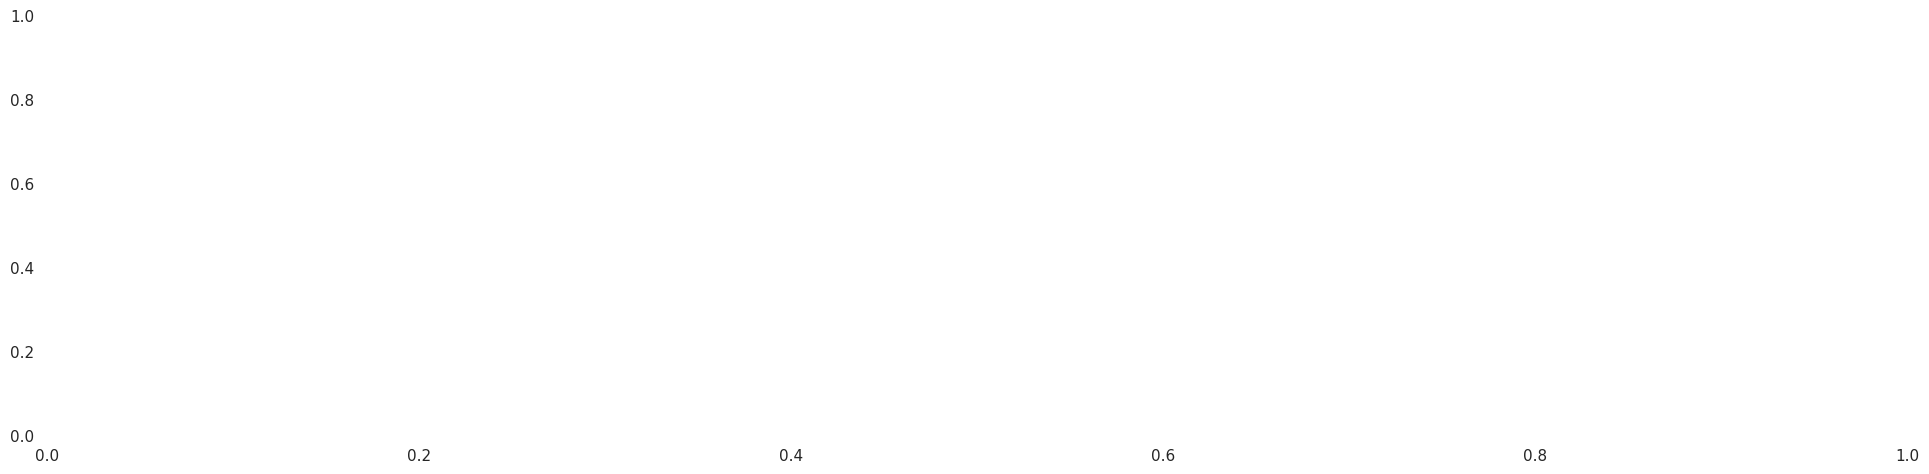

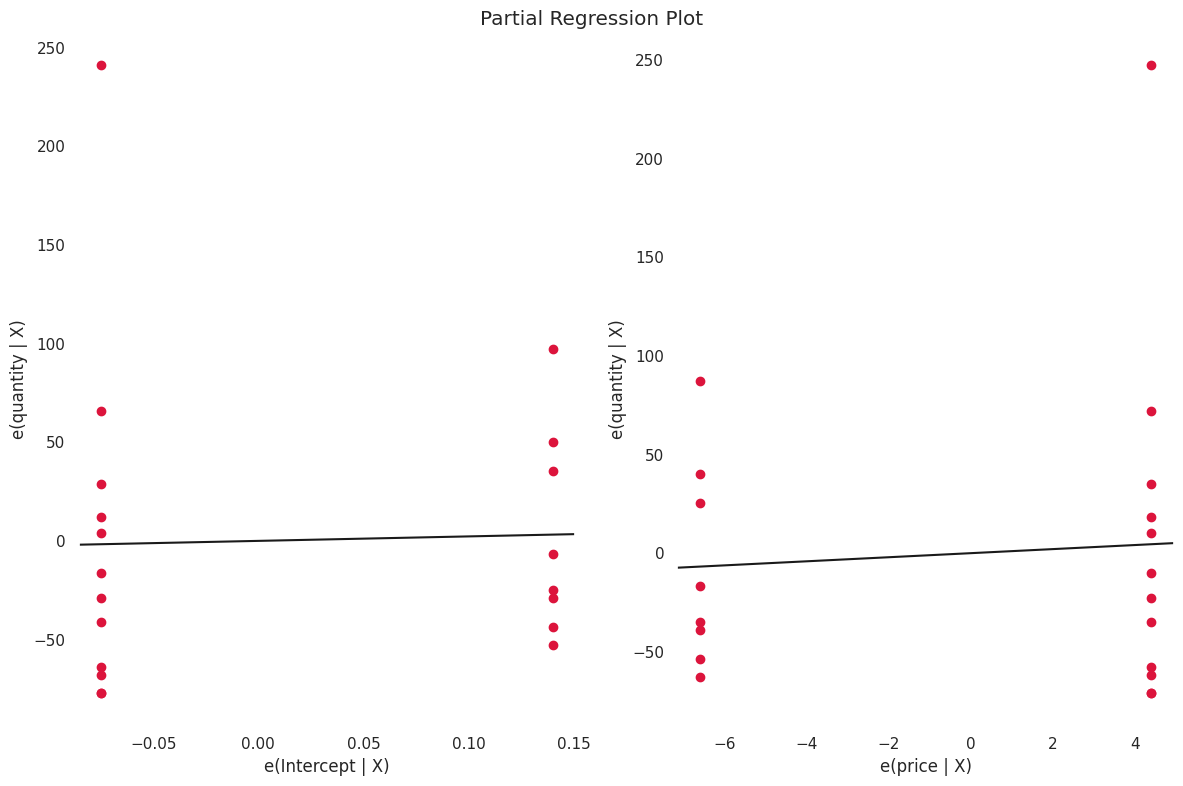

In [77]:
plt.subplot(2,1,1)

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(product_59, fig=fig)

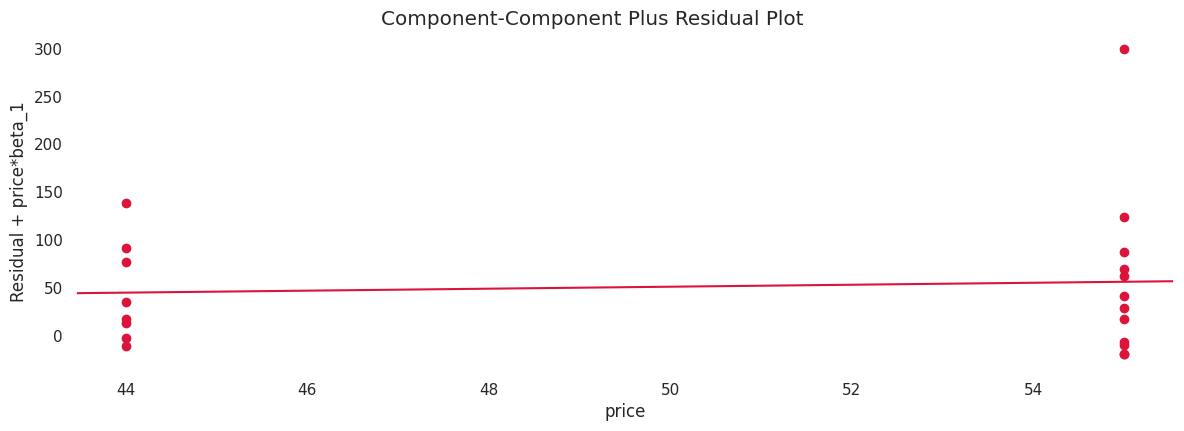

In [78]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(product_59, fig=fig)


eval_env: 1


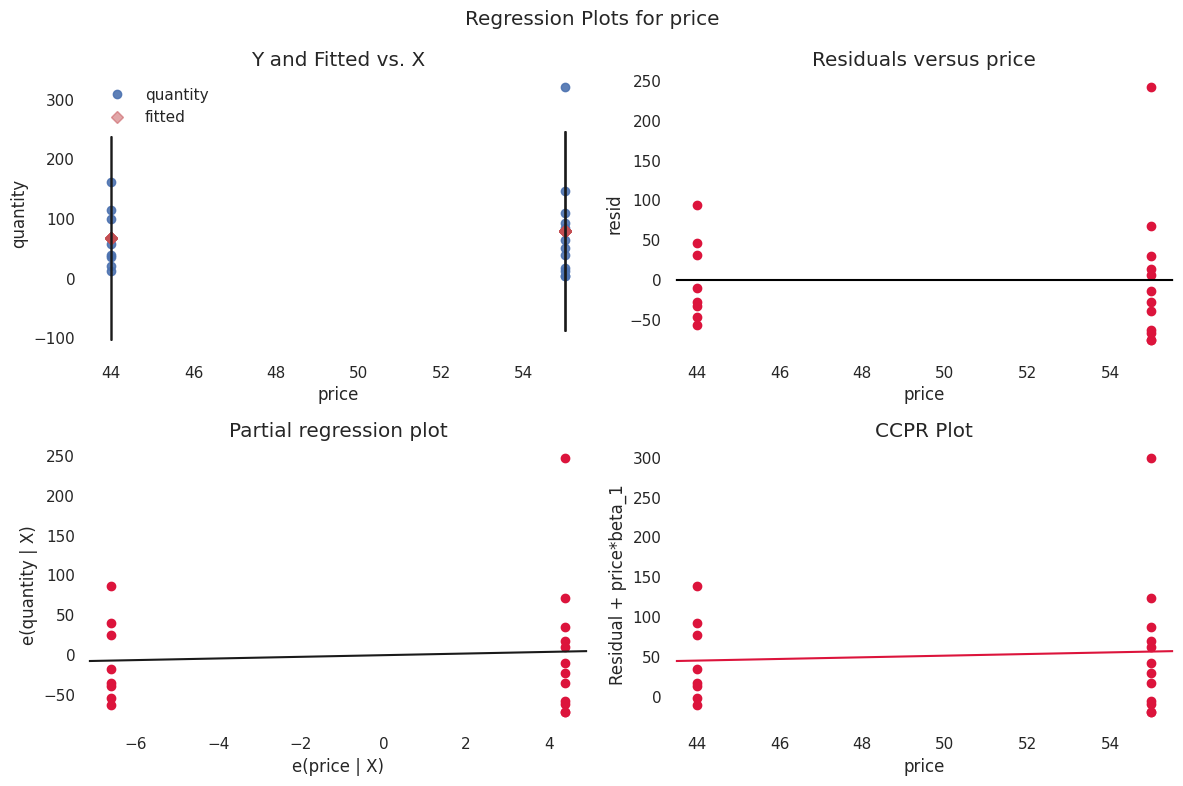

In [79]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(product_59, 'price', fig=fig)

# 8.0. KPI's

In [80]:
kpi = orders_info.copy()
kpi['year_mounth'] = kpi.order_date.apply(lambda x: x.strftime('%Y-%m'))

## 8.1. Financial and administrative management

### Revenue

In [81]:
revenue = np.round(orders_info.query('order_year == 1998').final_price.sum(),2)
print(f'Revenue: {revenue}')

Revenue: 469734.6


Text(0.5, 1.0, 'Revenue per month')

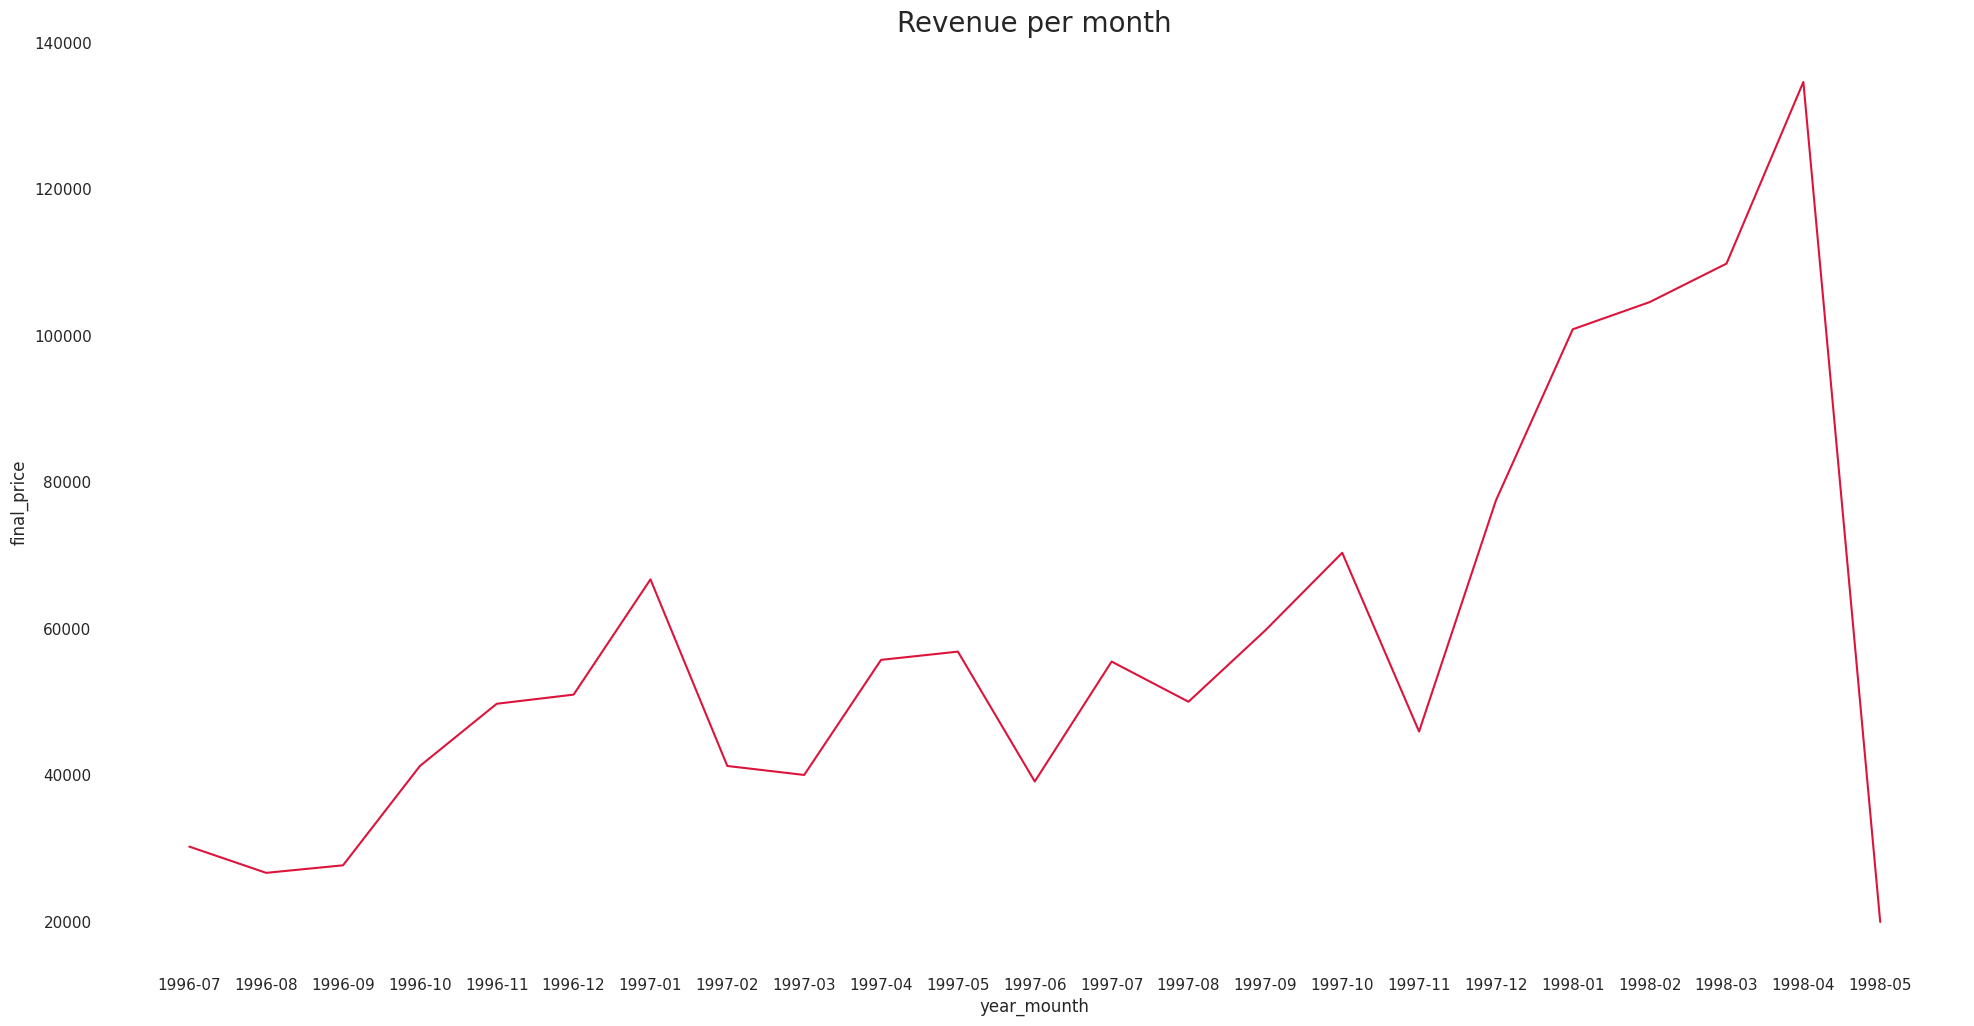

In [82]:
aux = kpi.groupby('year_mounth')[['final_price']].sum().reset_index()
sns.lineplot(data=aux, x='year_mounth', y='final_price');
plt.title('Revenue per month', fontsize=20)

In [83]:
# This drop in the chart is because month 05 has just started

## 8.2. Customer perspective

#### Number of Customers

In [84]:
number_customer = customer_info.customer_id.count()
print(f'The number of customers is {number_customer}')

The number of customers is 89


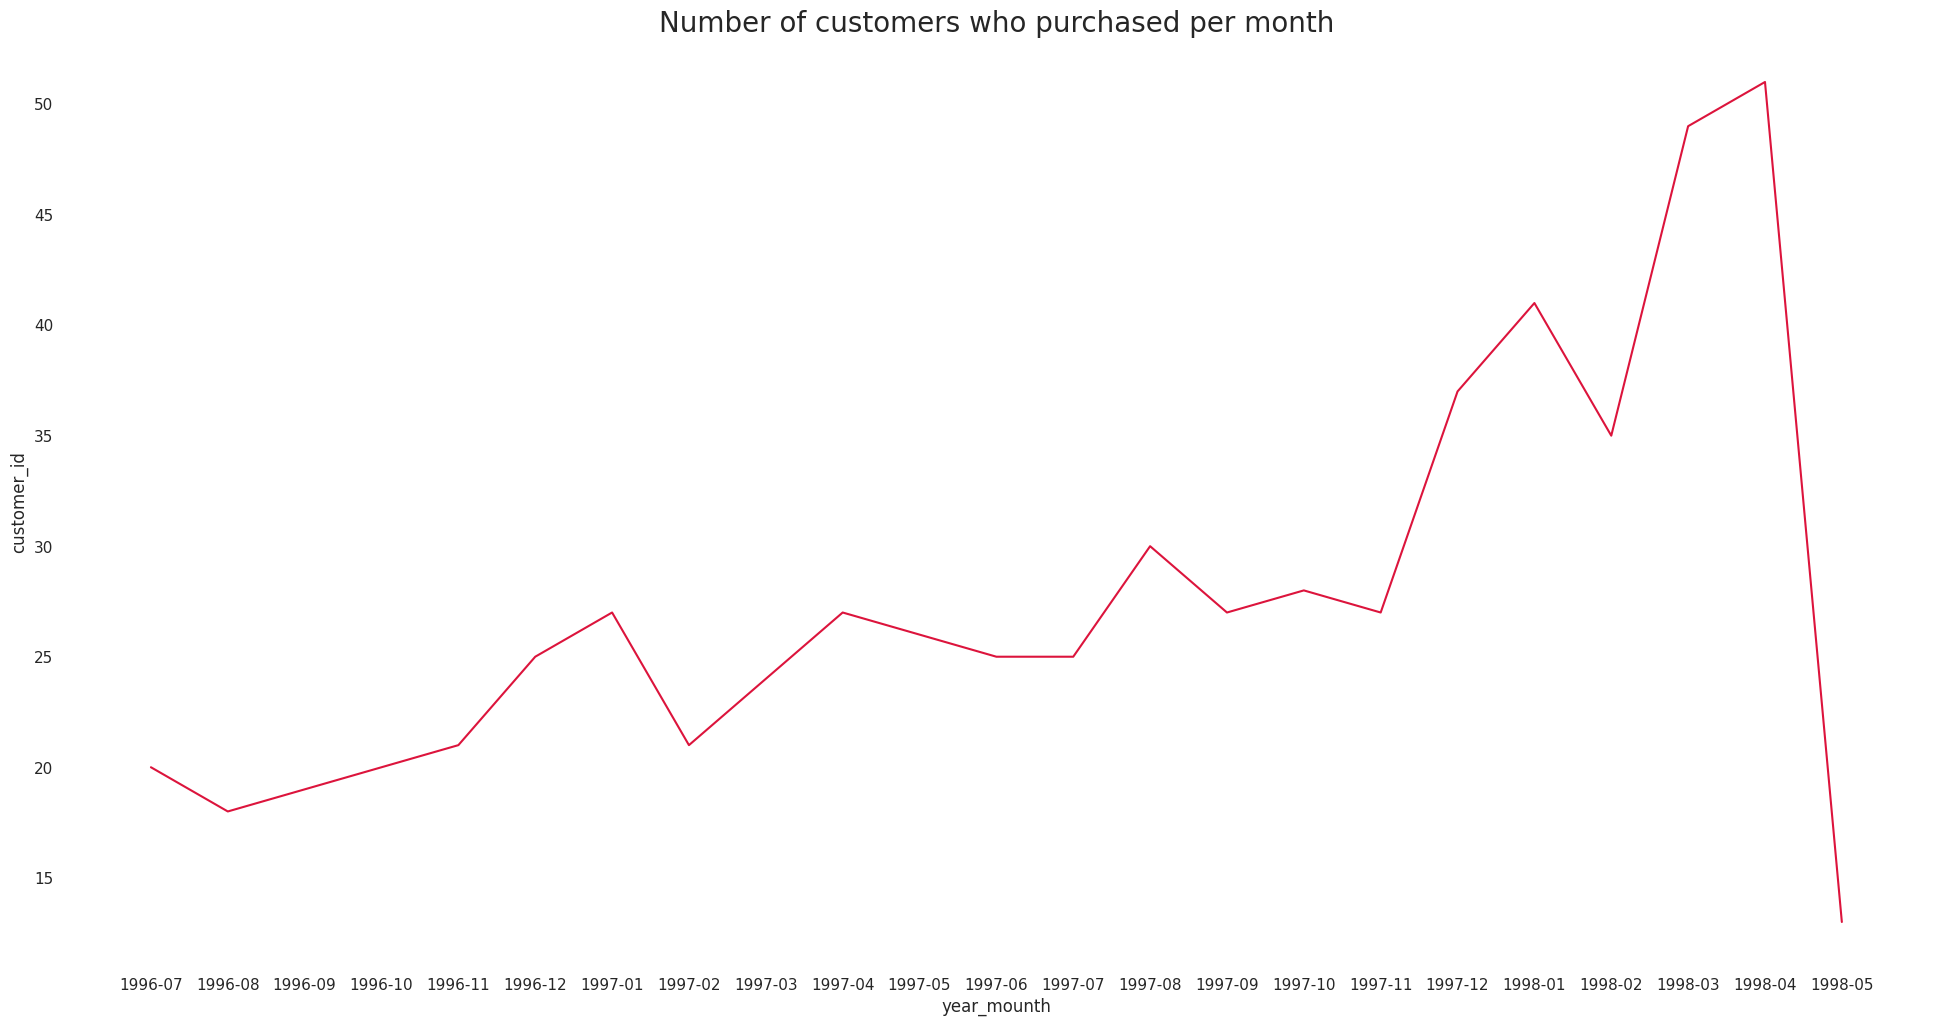

In [85]:
aux = kpi.groupby('year_mounth')[['customer_id']].nunique().reset_index()
sns.lineplot(data=aux, x='year_mounth', y='customer_id');
plt.title('Number of customers who purchased per month', fontsize=20);

In [86]:
# This drop in the chart is because month 05 has just started

#### Churn rate

In [87]:
churn_rate = np.round(customer_info.churn.mean()*100,2)
print(f'Churn rate: {churn_rate}')

Churn rate: 20.22


#### Average Ticket

In [88]:
customer_info[['customer_id', 'average_ticket']].head()

,customer_id,average_ticket
0,ALFKI,765.86
1,ANATR,350.74
2,ANTON,1073.48
3,AROUT,1061.98
4,BERGS,1498.06


#### CLTV

In [93]:
def cltv_dataframe( df, profit_rate , repeat_customers=2):
    # copy the dataframe
    df_cp = df.copy()
    
    # the minimum number of purchases a frequent customer must have
    repeat_customers = repeat_customers
    
    # gets the max date
    max_date = df_cp.order_date.max()
    
    # calculate the lifetime - num_transaction - quantity - total_revenue
    data = df_cp.groupby('customer_id').agg(
                      {'order_date': lambda x: (max_date-x.min()).days,
                       'order_id': lambda x: len(x),
                       'quantity': lambda x: x.sum(),
                       'final_price': lambda x: x.sum()})
    
    # rename the columns
    data.columns = ['lifetime','num_transactions','quantity', 'total_revenue']
    
    # insure that we dont have 0 quantity
    data = data.query('quantity > 0')
    
    # calculate the AOV - Average Order Value
    data['AOV'] = data.total_revenue / data.num_transactions
    
    # calculate the purchase_frequency
    purchase_frequency = data['num_transactions'].sum() / len(data)
    
    # calculate the repeate rate
    repeat_rate = data.query('num_transactions > @repeat_customers').shape[0] / data.shape[0]
    
    # calculate the churn rate
    churn_rate = 1-repeat_rate
    
    # calculate the profit margin
    data['profit_margin'] = data.total_revenue * profit_rate

    # calculate the CLTV - Customer Life Time Value
    data['CLTV'] = ((data.AOV * purchase_frequency ) / churn_rate ) * profit_rate
    
    return data

In [94]:
# to calculate CLTV i assume the profit rate as 10%

In [95]:
cltv_table = cltv_dataframe( kpi, 0.1)
cltv_table

,lifetime,num_transactions,quantity,total_revenue,AOV,profit_margin,CLTV
customer_id,,,,,,,
ALFKI,254,12,174,4595.15,382.929167,459.515,41260.617708
ANATR,595,10,63,1402.95,140.295000,140.295,15116.786250
ANTON,525,17,359,7514.35,442.020588,751.435,47627.718382
AROUT,537,30,650,13805.80,460.193333,1380.580,49585.831667
BERGS,632,52,1001,26965.15,518.560577,2696.515,55874.902163
...,...,...,...,...,...,...,...
WARTH,649,37,737,16615.10,449.056757,1661.510,48385.865541
WELLI,660,19,267,6479.15,341.007895,647.915,36743.600658
WHITC,644,40,1063,29070.70,726.767500,2907.070,78309.198125


In [96]:
print(f"The median CLTV is {cltv_table.CLTV.median()}")
print(f"The median CLTV is {cltv_table.CLTV.mean()}")

The median CLTV is 48385.86554054042
The median CLTV is 52256.22426809249


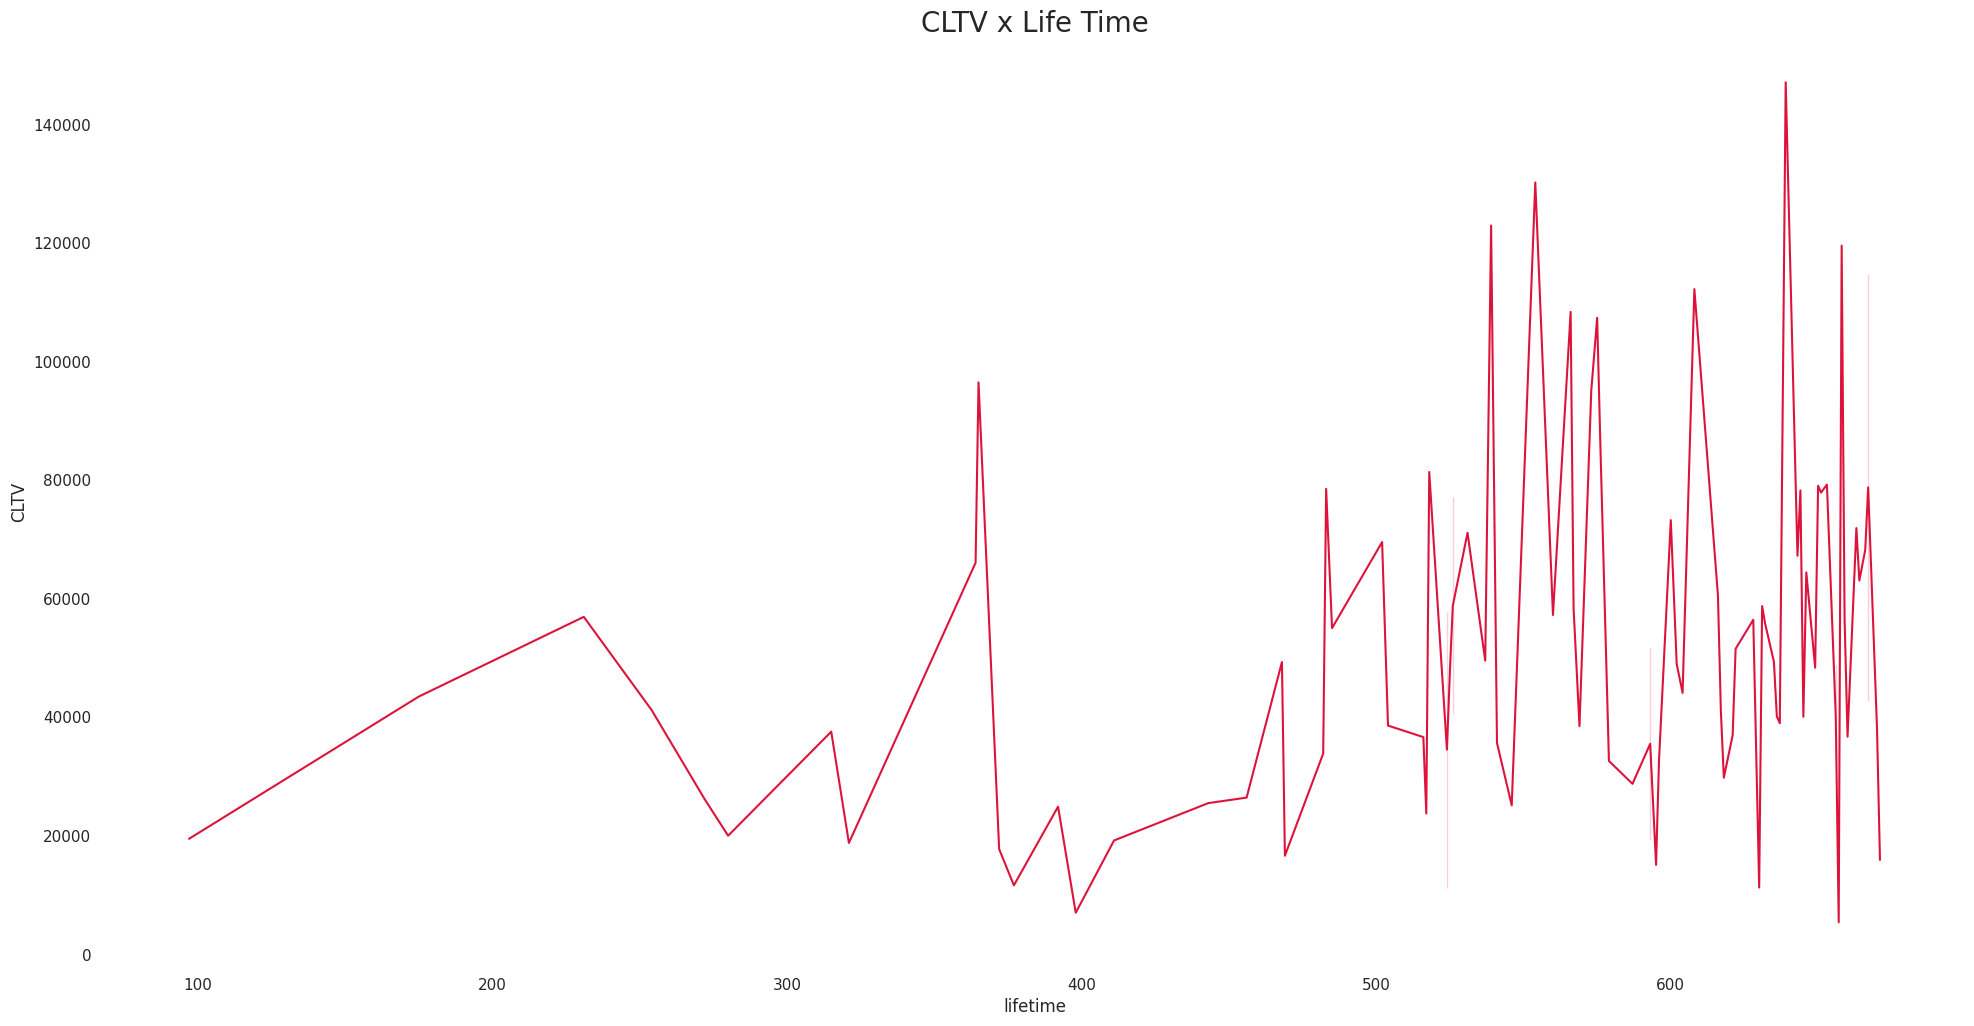

In [97]:
sns.lineplot(cltv_table, x='lifetime', y='CLTV');
plt.title('CLTV x Life Time', fontsize=20);

### 8.3. Processes Management

#### Average delayed days

In [98]:
avg_delayed_days = orders_info.query('delayed_days > 0')['delayed_days'].mean()
print(f'The Average Delayed Days: {avg_delayed_days}')

The Average Delayed Days: 6.173913043478261


#### Assortment

In [99]:
assortment = products.product_id.nunique()
print(f'The number of assortment is {assortment}')

The number of assortment is 77
